In [1]:
import numpy as np
import pandas as pd
import re
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import time
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
movies = pd.read_csv("../movies.csv", index_col = 0)

In [3]:
interactions = pd.read_csv("../interactions.csv", index_col=0)

In [4]:
movies

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,movieId,title,genres
5,1903,alice in wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab...",1032.0,alice in wonderland,Adventure|Animation|Children|Fantasy|Musical
6,1903,the great train robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...,6990.0,the great train robbery,Action|Adventure|Comedy|Crime|Drama
27,1910,frankenstein,American,J. Searle Dawley,"Augustus Phillips, Charles Stanton Ogle, Mary ...",unknown,https://en.wikipedia.org/wiki/Frankenstein_(19...,"Described as ""a liberal adaptation of Mrs. She...",2648.0,frankenstein,Drama|Horror|Sci-Fi
31,1910,pocahontas,American,Unknown,"Anna Rosemond, George Barnes, Frank H. Crane",short fantasy,https://en.wikipedia.org/wiki/Pocahontas_(1910...,"Though the film is presumed lost, a synopsis s...",48.0,pocahontas,Animation|Children|Drama|Musical|Romance
43,1912,dr. jekyll and mr. hyde,American,Lucius Henderson,James Cruze,horror,https://en.wikipedia.org/wiki/Dr._Jekyll_and_M...,White-haired Dr. Jekyll has secretly locked hi...,7208.0,dr. jekyll and mr. hyde,Drama|Horror
...,...,...,...,...,...,...,...,...,...,...,...
32160,2013,snowpiercer,South_Korean,Bong Joon-ho,"Chris Evans, Song Kang-ho",unknown,https://en.wikipedia.org/wiki/Snowpiercer,"In 2014, an attempt to counteract global warmi...",107406.0,snowpiercer,Action|Drama|Sci-Fi
32205,2014,man on high heels,South_Korean,Jang Jin,"Cha Seung-won, Oh Jung-se",unknown,https://en.wikipedia.org/wiki/Man_on_High_Heels,Yoon Ji-wook is a hard-as-nails homicide detec...,120919.0,man on high heels,Action|Comedy
32296,2016,the wailing,South_Korean,Na Hong-jin,"Kwak Do-won, Hwang Jung-min, Chun Woo-hee",unknown,https://en.wikipedia.org/wiki/The_Wailing_(film),A Japanese man has recently arrived at a littl...,159061.0,the wailing,Mystery|Thriller
32297,2016,the handmaiden,South_Korean,Park Chan-wook,"Kim Min-hee, Kim Tae-ri, Ha Jung-woo",unknown,https://en.wikipedia.org/wiki/The_Handmaiden,"In Japanese-occupied Korea, a conman operating...",158783.0,the handmaiden,Drama|Romance|Thriller


In [5]:
interactions

,userId,movieId,timestamp
0,1,1,964982703
1,1,3,964981247
2,1,6,964982224
5,1,70,964982400
6,1,101,964980868
...,...,...,...
100827,610,163937,1493848789
100831,610,166534,1493848402
100833,610,168250,1494273047
100834,610,168252,1493846352


In [6]:
movies.Plot.apply(len).max()

25123

In [7]:
movies.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'movieId', 'title', 'genres'],
      dtype='object')

In [8]:
movies["Origin/Ethnicity"].value_counts()

Origin/Ethnicity
American        4183
British          340
Canadian          77
Australian        48
Japanese          42
Bollywood         15
Hong Kong         12
Chinese            9
Russian            8
South_Korean       7
Malayalam          3
Telugu             2
Bangladeshi        1
Bengali            1
Kannada            1
Tamil              1
Name: count, dtype: int64

In [9]:
movies["Director"].nunique()

2299

In [10]:
movies.Cast.iloc[10].split(", ")

['Theda Bara', 'Alan Roscoe']

In [11]:
allmovies = movies.Cast.apply(lambda x: x.split(", ") if type(x) is str else  []) 
len(set([movie for movies in allmovies for movie in movies]))

6676

In [12]:
allgenres = movies.Genre.apply(lambda x: x.split(", ") if type(x) is str else  []) 
len(set([genre for genres in allgenres for genre in genres]))

283

In [13]:
allgenres = movies.genres.apply(lambda x: x.split("|") if type(x) is str else []) 
len(set([genre for genres in allgenres for genre in genres]))

20

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

In [15]:
class OtherTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 10):
        self.threshold = threshold
        self.dict = {}
    def fit(self, X, y=None):
        self.dict = {}
        for col in X:
            vc = X.value_counts() < self.threshold
            self.dict[col] = {cat[0]: "Other" if cond else cat[0]
                              for cat, cond in zip(vc.index, vc)}
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.dict:
            X[col] = X[col].apply(lambda x: self.dict[col][x])
        return X
    def set_output(self, *args, **kwargs):
        pass

In [16]:
onehot = Pipeline([
        ("Other", OtherTransformer(threshold = 5)),
        ("OneHot", OneHotEncoder(sparse_output=False)),
    ])

onehot.fit_transform(movies[["Origin/Ethnicity"]])

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
class SplitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sep = ","):
        self.sep = sep
        self.mlb = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        X = X.applymap(lambda x: x.split(self.sep) if type(x) is str else [])
        for col in X:
            self.mlb[col] = MultiLabelBinarizer().fit(X[col])
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X = X.applymap(lambda x: x.split(self.sep) if type(x) is str else [])
        return np.hstack([self.mlb[col].transform(X[col]) for col in X])
    def set_output(self, *args, **kwargs):
        pass

In [18]:
SplitTransformer("|").fit_transform(movies[["genres"]])

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]])

In [19]:
ct = ColumnTransformer([
    ("Normalize", StandardScaler(), ["Release Year"]),
    ("Multilabel", SplitTransformer("|"), ["genres"]),
    ("OneHotOther", Pipeline([
        ("Other", OtherTransformer(threshold = 5)),
        ("OneHot", OneHotEncoder(sparse_output=False)),
    ]), ["Origin/Ethnicity"])
], remainder = "drop")

ct.fit_transform(movies)[:, 31]

array([0., 0., 0., ..., 1., 1., 1.])

In [20]:
from nltk.tokenize import word_tokenize

In [21]:
plot_lengths = movies.Plot.apply(word_tokenize).apply(len)

(0.0, 2000.0)

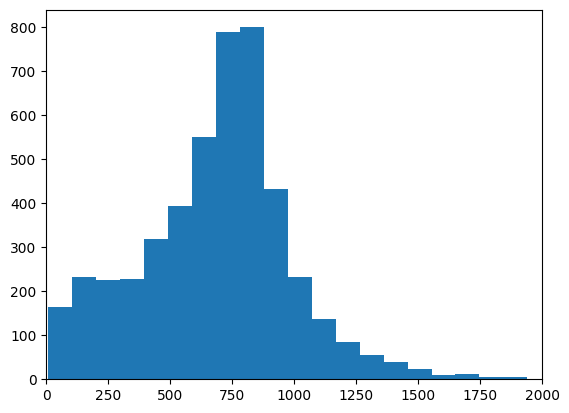

In [22]:
import matplotlib.pyplot as plt

plt.hist(plot_lengths, bins = 60)
plt.xlim([0,2000])

In [1505]:
class TextTransformer():
    def __init__(self, corpus, preprocessor, seq_length = 1000, vocab = None, vocab_to_int = None):

        self.preprocess = preprocessor
        
        if vocab is None:
            corpus= [
                txt.lower()
                for text in corpus
                for txt in self.preprocess(text)
            ]

            self.vocab = list(set(corpus))
        else:
            self.vocab = vocab
        self.vocab_to_int = {word:idx for idx, word in enumerate(self.vocab, 1
                                                                )} if vocab_to_int is None else vocab_to_int

        self.seq_length = seq_length

    def __call__(self, words):
        ints = np.zeros(self.seq_length, dtype=int)
        
        words = self.preprocess(words)[:self.seq_length]
        
        ints[:min(len(words), self.seq_length)] = np.array([
            self.vocab_to_int[word.lower()] if word.lower() in self.vocab_to_int else 0
            for word in words])

        return (ints, len(words))
    
tt = TextTransformer(movies.Plot.iloc[:1000], word_tokenize)

In [24]:
class movie_dataset:
    def __init__(self, interactions, features, text, movie_ids, transform= None, text_transformed = False):
        self.transform = transform
        
        self.movie_id_to_idx = {int(movie_id):idx for idx, movie_id in enumerate(movie_ids)}
        
        self.interactions = interactions.reset_index(drop = True)
        self.features = np.array(features)
        
        if text_transformed:
            self.text, self.lengths = text
        else:
            self.text, self.lengths = zip(*[self.transform(txt) for txt in text])
            self.text = np.array(self.text)
            self.lengths = np.array(self.lengths)
    def __len__(self):
        return self.interactions.shape[0]
    def get_data(self, movie_id):
        movie_idx = self.movie_id_to_idx[movie_id]
        
        text     = self.text[movie_idx]
        lengths   = self.lengths[movie_idx]
        features = self.features[movie_idx]
        
        text     = torch.tensor(text)
        lengths  = torch.tensor(lengths)
        features = torch.tensor(features, dtype = torch.float32)
        
        return (text, features, lengths)
    def __getitem__(self, idx):
        movie_id = self.interactions.loc[idx, "movieId"]
        user_id  = self.interactions.loc[idx, "userId"]
        target   = torch.tensor(user_id)
        
        return (self.get_data(movie_id), target)

In [25]:
movies = movies.set_index("movieId")

In [26]:
interactions_train = interactions[interactions.userId<=530]
interactions_test  = interactions[interactions.userId>530]

In [38]:
def get_negative_samples(interactions):
    inter = interactions.iloc[:, :2].to_numpy()
    
    uniq_1 = interactions.iloc[:, 0].unique()
    uniq_2 = interactions.iloc[:, 1].unique()
    
    indexes_1 = np.arange(max(uniq_1)+1)
    indexes_2 = np.arange(max(uniq_2)+1)
    indexes_1[uniq_1] = range(len(uniq_1))
    indexes_2[uniq_2] = range(len(uniq_2))
    
    matrix = np.zeros((len(uniq_1), len(uniq_2)))
    matrix[indexes_1[inter[:, 0]], indexes_2[inter[:, 1]]] = 1
    
    matrix = matrix.flatten()
    index_grid_2, index_grid_1 = [v.flatten() for v in np.meshgrid(uniq_2, uniq_1)]
    
    output = pd.DataFrame(columns = interactions.columns)
    output.iloc[:, 0] = index_grid_1[matrix==0]
    output.iloc[:, 1] = index_grid_2[matrix==0]
    
    return output

#neg_val = get_negative_samples(interactions_val)

In [39]:
interactions_neg = get_negative_samples(interactions_train)

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size = 0.15, n_splits = 2, random_state = 1991)

In [41]:
i_train,     i_val     = list(sss.split(interactions_train, interactions_train.userId))[0]
i_train_neg, i_val_neg = list(sss.split(interactions_neg,   interactions_neg.userId))[0]

In [670]:
interactions_train     = interactions.iloc[i_train]
interactions_val       = interactions.iloc[i_val]
interactions_train_neg = interactions_neg.iloc[i_train_neg]
interactions_val_neg   = interactions_neg.iloc[i_val_neg]

freq_ratio = interactions_train.userId.value_counts()/interactions_val.userId.value_counts()
print(freq_ratio.mean(), freq_ratio.std())

5.741355399908703 0.5945667373822746


In [671]:
print(len(interactions_train), len(interactions_test), len(interactions_val))
print(len(interactions))
len(interactions_train)+ len(interactions_test)+ len(interactions_val)

44684 10862 7886
63432


63432

In [672]:
print(len(interactions_train_neg), len(interactions_val_neg))
print(len(interactions_neg))
len(interactions_train_neg) +len(interactions_val_neg)

1934362 341358
2275720


2275720

In [673]:
print(interactions_train.userId.nunique(), interactions_val.userId.nunique())

530 530


In [674]:
movies_in_train = pd.Series(movies.index).isin(interactions_train.movieId)
print(movies_in_train.sum(), movies.shape[0] - movies_in_train.sum())

4210 540


In [1542]:
tt = TextTransformer(movies[movies_in_train.to_numpy()].Plot, word_tokenize)

NameError: name 'movies_in_train' is not defined

In [42]:
movies_data = ct.fit_transform(movies)

In [677]:
movies_data[movies_in_train.to_numpy()].max(axis=0)

array([1.22290407, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

In [678]:
train_set     = movie_dataset(
    interactions_train, movies_data, movies.Plot, movies.index, transform = tt)

train_set_neg = movie_dataset(
    interactions_train_neg, movies_data, (train_set.text, train_set.lengths), 
    movies.index, transform = tt, text_transformed = True)

val_set       = movie_dataset(
    interactions_val, movies_data, (train_set.text, train_set.lengths), 
    movies.index, transform = tt, text_transformed = True)

val_set_neg   = movie_dataset(
    interactions_val_neg, movies_data, (train_set.text, train_set.lengths), 
    movies.index, transform = tt, text_transformed = True)

test_set      = movie_dataset(
    interactions_test,  movies_data, (train_set.text, train_set.lengths), 
    movies.index, transform = tt, text_transformed = True)

In [679]:
(interactions_test.movieId == 170551.0).reset_index(drop=True).argmax()

7422

In [708]:
class NegativeSampler:
    def __init__(self, pos_set, neg_set, batch_size = 2, positive_ratio = 0.5):
        self.positive_ratio = positive_ratio
        self.batch_size = batch_size
        
        self.pos_loader = DataLoader(pos_set, batch_size = self.batch_size_pos, shuffle=True)
        self.neg_loader = DataLoader(neg_set, batch_size = self.batch_size_neg, shuffle=True)
        
        self.pos_iterator = iter(self.pos_loader)
        self.neg_iterator = iter(self.neg_loader)
    def __len__(self):
        return len(self.pos_loader)
    def __iter__(self):
        self.pos_iterator = iter(self.pos_loader)
        return self
    def recursive_stack(self, x,y):
        if type(x) in (list, tuple):
            return tuple([self.recursive_stack(i, j) for i, j in zip(x,y) ])
        else:
            return torch.cat((x, y))
    def __next__(self):
        next_pos = next(self.pos_iterator)
        
        try:
            next_neg = next(self.neg_iterator)
        except StopIteration:
            self.neg_iterator = iter(self.neg_loader)
            next_neg = next(self.neg_iterator)
        
        b_size = lambda x: b_size(x[0]) if type(x) in (list, tuple) else len(x)
        return  self.recursive_stack((next_pos,  torch.ones(b_size(next_pos))), 
                                     (next_neg, -torch.ones(b_size(next_neg))))
            
    @property
    def batch_size_pos(self):
        return int(self.batch_size * self.positive_ratio)
    @property
    def batch_size_neg(self):
        return self.batch_size - self.batch_size_pos

In [814]:
batch_size = 50
train_loader = NegativeSampler(train_set, train_set_neg, batch_size = batch_size, positive_ratio = 0.1)
val_loader   = NegativeSampler(val_set,   val_set_neg,   batch_size = batch_size, positive_ratio = 0.1)
test_loader  = DataLoader(test_set,   batch_size = batch_size, shuffle=True)

In [815]:
for (((text, features, lengths), target), sign) in val_loader:
    pass

print(text)

tensor([[49913, 19189,   437,  ...,     0,     0,     0],
        [55308, 20208, 56296,  ...,     0,     0,     0],
        [61269, 38301, 30886,  ...,     0,     0,     0],
        ...,
        [ 6606, 18424,  7479,  ...,     0,     0,     0],
        [47893, 52838, 58052,  ...,     0,     0,     0],
        [58000, 45460, 43460,  ...,     0,     0,     0]], dtype=torch.int32)


In [816]:
class MovieNet(nn.Module):
    def __init__(self, embedding_dim, vocab_size, lstm_dim, lstm_layers, n_features, 
                 hidden_dim, output_dim, n_users, drop_prob=0.2, bidirectional = False):
        
        super(MovieNet, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.users     = nn.Embedding(n_users,    output_dim,    padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, lstm_dim, lstm_layers,
                            dropout=drop_prob, batch_first=True, bidirectional = bidirectional)

        self.dropout = nn.Dropout(drop_prob)
        
        # Capas lineales y salida
        self.fc1 = nn.Linear(lstm_dim*(1+bidirectional) + n_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.fun = nn.ReLU()

    def forward(self, text, features, lengths):
        
        x = self.embedding(text)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = False)
        x, _ = self.lstm(x)
        x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first = True)   
        
        #Tomamos solo el último valor de salida del LSTM
        x = x[:,-1,:]
        
        # Concatenamos con features
        x = torch.hstack((x, features))
        x = self.dropout(x)
        
        # Capas finales y salida
        x = self.fc1(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [817]:
movies_data.shape

(4750, 32)

In [818]:
net = MovieNet(256, len(train_set.transform.vocab)+1, 64, 2, 32, 64, 32, 611, drop_prob=0.4)

In [819]:
(test_data, test_target), test_sign = next(iter(train_loader))

In [820]:
net(*test_data)

tensor([[-0.0249, -0.2008, -0.0611,  ..., -0.0327, -0.0693, -0.0036],
        [ 0.1367, -0.1191, -0.1185,  ..., -0.0491,  0.1579, -0.1556],
        [ 0.0473, -0.2900, -0.1709,  ..., -0.1045,  0.0969, -0.3055],
        ...,
        [ 0.0185, -0.0804,  0.0184,  ..., -0.0483, -0.0208, -0.2665],
        [ 0.0642,  0.0251, -0.0817,  ..., -0.1891,  0.0489, -0.1130],
        [-0.0602, -0.1357,  0.0050,  ..., -0.1578,  0.0643, -0.0481]],
       grad_fn=<AddmmBackward0>)

In [821]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.CosineEmbeddingLoss(margin = -1)
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [822]:
class Metrics:
    def __init__(self, keys):
        self.data = {key: Metrics(keys[1:]) if len(keys)>1 else [] for key in keys[0]}
        self.__dict__.update(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def dataframe(self):
        def rec(metric, name):
            if isinstance(metric, Metrics):
                ret = {key: rec(metric[key], key) for key in metric.data}
                if type(list(ret.values())[0]) is list:
                    return {name+"_"+k:ret[k] for k in ret}
                return {name+"_"+subkey:ret[key][subkey] for key in ret for subkey in ret[key]}
            else:
                return metric
        data = rec(self, "")
        return pd.DataFrame({key[1:]:data[key] for key in data})

In [823]:
# Clase que entrena el modelo
def train_model(model, criterion, optimizer, train_loader, val_loader = None, epochs=8, save_criterium = "loss"):
    since = time.time()
    dataloaders = {"train":train_loader, "val":val_loader}
    device = "cuda" if train_on_gpu else "cpu"
    model.to(device)
    metric = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])
    bar_epoch = tqdm(range(epochs))
    bar_train = tqdm(range(len(train_loader)))
    best_epoch, best_crit = 0, None

    bar_epoch.set_description_str(f"Epoch 0 ")
    for epoch in range(epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            if dataloaders[phase] is not None:

                running_loss = 0.0
                running_corrects = 0
                batch_size = 0

                # Iterate over data.
                for batch, (((text, features, lengths), labels), sign) in enumerate(dataloaders[phase]):
                    
                    labels, text, features = labels.to(device), text.to(device), features.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward only if phase is train
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(text, features, lengths)
                        users   = model.users(labels)
                        
                        loss = criterion(outputs, users, sign.to(device))
                        
                        if phase == 'train':
                            loss.backward() #retain_graph = True
                            optimizer.step()
                            
                            bar_train.set_description_str(f"Batch {batch} of {len(dataloaders[phase])}")
                            bar_train.update()
                    # statistics
                    running_loss += loss.item() * labels.size(0)
                    batch_size += labels.size(0)

                loss_value = running_loss / batch_size
                metric[phase].loss.append(loss_value)
                criterium = -loss_value

                if phase == 'val' and (best_crit is None or criterium > best_crit):
                    best_epoch, best_crit = epoch, criterium
                    torch.save(model.state_dict(), 'bestmodel.pt')

        bar_epoch.set_description_str(f"Epoch: {epoch+1} | Train Loss: {metric.train.loss[-1]:.4f} | Val Loss: \
        {metric.val.loss[-1]:.4f} | Best {save_criterium[:3]}: {best_crit:.4f}")

        bar_train.n = 0
        bar_epoch.update()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return metric, model

In [824]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [825]:
metrics_1, net = train_model(net, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=1, save_criterium = "loss")

metrics.train.loss = metrics_1.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics_1.val.loss   + metrics_1.val.loss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8937 [00:00<?, ?it/s]

Training complete in 25m 29s


In [214]:
np.save("metrics_2", metrics_1)

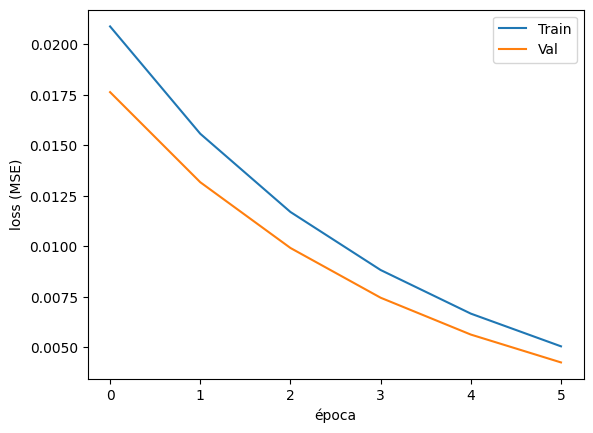

In [213]:
plt.plot(metrics_1.train.loss, label="Train")
plt.plot(metrics_1.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

In [48]:
net.load_state_dict(torch.load("bestmodel.pt"))

<All keys matched successfully>

In [718]:
torch.cuda.empty_cache()

In [719]:
torch.cuda.memory_allocated()

394916864

In [257]:
def cosine_similarity(x, y, smooth = True):
    dot = np.sum(x*y, axis = -1)
    norm = (np.linalg.norm(x, axis=-1) * np.linalg.norm(y, axis=-1)) + 1e-320 if smooth else 0
    return dot/norm

In [782]:
class Recommender:
    def __init__(self, net, movies, interactions, dataset, batch_size = 20):
        self.net = net
        self.movies = movies
        self.interactions = interactions
        self.dataset = dataset
        self.movie_embeddings = self.get_movie_embeddings(batch_size = batch_size)
    def get_movie_embeddings(self, batch_size = 20):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net.to(device)
        movie_ids = self.movies.index
        embeds = []
        bar = tqdm(range(0, len(movie_ids), batch_size))
        bar.set_description_str("Calculating movie embeddings")
        for i in range(0, len(movie_ids), batch_size):
            text, features, lengths = zip(*[self.dataset.get_data(ide) for ide in movie_ids[i:i+batch_size]])
            text, features, lengths = torch.vstack(text), torch.vstack(features), torch.hstack(lengths)
            embed = self.net(text.to(device), features.to(device), lengths)
            embeds += [embed.cpu().detach().numpy()]
            bar.update()
        return np.vstack(embeds)
    
    def get_new_embedding(self, movie_ids, mean = True):
        indexs = [self.dataset.movie_id_to_idx[movie_id] for movie_id in movie_ids]
        embeddings = self.movie_embeddings[indexs]
        return embeddings.mean(axis =0) if mean else embeddings
    
    def recommend(self, user_id = None, movie_ids = None, n = "auto", from_embedding = False):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            if from_embedding:
                embedding = self.net.users(torch.tensor(user_id).cuda()).cpu().detach().numpy()
            else:
                embedding = self.get_new_embedding(
                    self.interactions[self.interactions.userId == user_id].movieId)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            embedding = get_new_embedding(movie_ids)
            n = len(movie_ids) if n == "auto" else n
        
        similarities = cosine_similarity(embedding, self.movie_embeddings)
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def recommend2(self, user_id = None, movie_ids = None, n = "auto", sigma = 0.2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            user_embeddings = self.get_new_embedding(
                self.interactions[self.interactions.userId == user_id].movieId, mean=False)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            user_embeddings = self.get_new_embedding(movie_ids, mean=False)
            n = len(movie_ids) if n == "auto" else n
            
        all_movie_embeddings = np.expand_dims(self.movie_embeddings, 1)
        user_embeddings      = np.expand_dims(user_embeddings, 0)
        similarities = cosine_similarity(user_embeddings, all_movie_embeddings)
        similarities = similarities.sum(axis =-1)
        
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def accuracy(self, user_id = None, movie_ids = None, n = "auto", method = 2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            movie_ids = self.interactions[self.interactions.userId == user_id].movieId
        
        recommend_method = self.recommend if method ==1 else self.recommend2
        recommendations = recommend_method(user_id = user_id, movie_ids = movie_ids, n=n)
        return len(set(recommendations).intersection(set(movie_ids))) / len(set(recommendations))


In [826]:
recommender = Recommender(net, movies, interactions, train_set)

  0%|          | 0/238 [00:00<?, ?it/s]

In [828]:
recommender.accuracy(1)

0.05161290322580645

In [736]:
a.shape

(4750,)

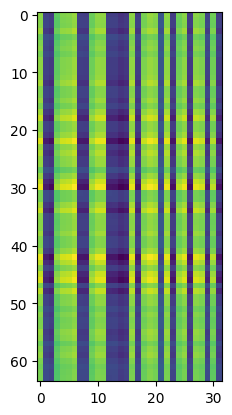

In [827]:
plt.imshow(recommender.movie_embeddings[-64:])

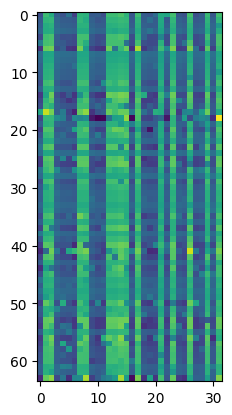

In [829]:
plt.imshow(net.users(torch.arange(1,611).cuda()).detach().cpu().numpy()[:64])

In [763]:
np.mean([recommender.accuracy(user_id, n=10) for user_id in range(1,611)])

0.06459016393442624

In [232]:
{1,2,3,4,5}.intersection({3,4,5,6,7})

{3, 4, 5}

In [67]:
mean_embeddings = np.vstack([
    get_new_embedding(
        interactions[interactions.userId == user_id].movieId)
    for user_id in interactions.userId.unique()])

In [68]:
mean_embeddings = torch.tensor(mean_embeddings)

In [74]:
user_embeddings = net.users(torch.tensor(range(1,611)).cuda()).cpu().detach()

In [77]:
similarities = F.cosine_similarity(mean_embeddings, user_embeddings).numpy()

(array([  1.,   0.,   2.,   2.,   2.,   6.,  13.,  18.,  23.,  29.,  29.,
         36.,  49.,  46.,  37.,  45.,  55.,  42.,  53., 122.]),
 array([0.04673083, 0.09439195, 0.14205307, 0.18971418, 0.23737529,
        0.28503641, 0.33269754, 0.38035864, 0.42801976, 0.47568089,
        0.52334201, 0.57100308, 0.61866421, 0.66632533, 0.71398646,
        0.76164758, 0.80930871, 0.85696977, 0.9046309 , 0.95229203,
        0.99995315]),
 <BarContainer object of 20 artists>)

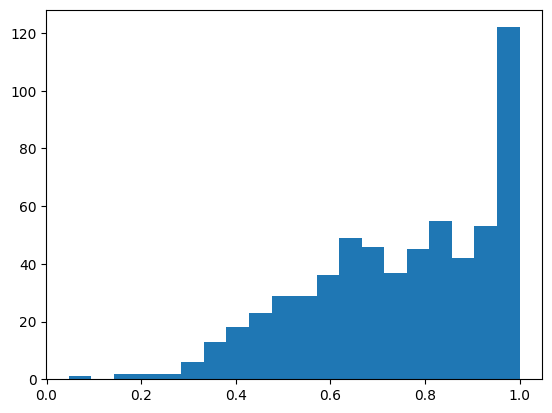

In [95]:
plt.hist(similarities, bins = 20)

# Approach 2

In [30]:
def interaction_matrix(interactions, movies):
    out = pd.DataFrame(0, columns = interactions.userId.unique(), index = movies.index)
    for row in interactions.iloc[:, :2].to_numpy():
        out.loc[row[1], row[0]]+=1
    return out

In [47]:
class movie_dataset_2:
    def __init__(self, features, text, movie_ids, barcode, transform= None, text_transformed = False):
        self.transform = transform
        
        self.movie_ids = movie_ids
        self.movie_id_to_idx = {int(movie_id):idx for idx, movie_id in enumerate(movie_ids)}
        
        self.features = np.array(features)
        
        if text_transformed:
            self.text, self.lengths = text
        else:
            self.text, self.lengths = zip(*[self.transform(txt) for txt in text])
            self.text = np.array(self.text)
            self.lengths = np.array(self.lengths)
        
        self.barcode = np.array(barcode)
    def __len__(self):
        return self.features.shape[0]
    def get_data(self, movie_id):
        idx = self.movie_id_to_idx[movie_id]
        
        return self[idx]
    def __getitem__(self, idx):
        text     = self.text[idx]
        lengths   = self.lengths[idx]
        features = self.features[idx]
        
        text     = torch.tensor(text)
        lengths  = torch.tensor(lengths)
        features = torch.tensor(features, dtype = torch.float32)
        
        return (text, features, lengths)
    
    def cat(self, other):
        new = movie_dataset_2(self.features, (self.text, self.lengths), self.movie_ids, self.barcode,
                             transform = self.transform, text_transformed = True)
        new.text       = np.concatenate((new.text,       other.text))
        new.features   = np.concatenate((new.features,   other.features))
        new.lengths    = np.concatenate((new.lengths,    other.lengths))
        new.barcode    = np.concatenate((new.barcode,    other.barcode))
        new.movie_ids  = np.concatenate((new.movie_ids,  other.movie_ids))
        for movie_id in other.movie_id_to_idx:
            new.movie_id_to_idx[movie_id] = other.movie_id_to_idx[movie_id] + len(self)
        return new

In [32]:
interactions_train = interactions[interactions.userId<=530]
interactions_test  = interactions[interactions.userId>530]

In [33]:
barcoding = interaction_matrix(interactions_train, movies)

KeyboardInterrupt: 

In [36]:
movies_data = ct.fit_transform(movies)

In [37]:
from sklearn.model_selection import train_test_split

In [32]:
(movies_data_train, movies_data_val, barcoding_train, barcoding_val, movies_plot_train, 
 movies_plot_val) = train_test_split(movies_data, barcoding, movies.Plot, test_size = 0.2, random_state = 1991)

In [1543]:
tt = TextTransformer(movies_plot_train, word_tokenize)

In [79]:
train_set = movie_dataset_2(movies_data_train, movies_plot_train, movies_plot_train.index, barcoding_train,
                           transform = tt)

val_set   = movie_dataset_2(movies_data_val, movies_plot_val, movies_plot_val.index, barcoding_val,
                           transform = tt)

In [35]:
def cosine_similarity(x, y):
    dot = np.sum(x*y, axis = -1)
    norm = (np.linalg.norm(x, axis=-1) * np.linalg.norm(y, axis=-1))
    return dot/norm

In [36]:
def recursive_stack(args):
    if type(args[0]) in (list, tuple):
        return tuple([recursive_stack(arg) for arg in zip(*args) ])
    else:
        return torch.cat(args)

In [167]:
class SimilarityLoader:
    def __init__(self, dataset, similarity = None, method = "mean", batch_size = 10, fullbatch = 5000):
        self.dataset = dataset
        self.barcode = dataset.barcode
        self.method = method
        self.batch_size = batch_size
        self.fullbatch = fullbatch
        
        if similarity is None:
            self.calculate_similarity()
        else:
            self.similarity = similarity
        self.make_grid()
    def calculate_similarity(self):
        self.similarity = np.zeros((len(self.barcode), len(self.barcode)))
        bar = tqdm(range(len(self.barcode)))
        for i in range(len(self.barcode)):
            self.similarity[i] = cosine_similarity(self.barcode[i], self.barcode)
            bar.update()
    def make_grid(self):
        tria = np.tril(self.similarity, k=-1)
        tria = tria.flatten()[~np.isnan(tria.flatten())]
        self.zero = tria.mean() if self.method == "mean" else np.median(tria)
        self.similarity[np.identity(len(self.similarity)) == 1] = self.zero

        self.all_grid = np.array([ar.flatten() for ar in 
                                  np.meshgrid(range(len(self.barcode)), range(len(self.barcode)))]).T

        tria = np.where(np.triu(np.ones(self.similarity.shape)) == 1, np.nan, self.similarity)
        pos_filter = (tria > self.zero).flatten()
        neg_filter = (tria < self.zero).flatten()

        self.pos_grid = self.all_grid[pos_filter]
        self.neg_grid = self.all_grid[neg_filter]

        self.pos_score = self.similarity.flatten()[pos_filter] - self.zero
        self.neg_score = self.zero - self.similarity.flatten()[neg_filter]

        self.pos_score = self.pos_score / np.sum(self.pos_score)
        self.neg_score = self.neg_score / np.sum(self.neg_score)
        
    def sample(self):
        if self.fullbatch > min(len(self.pos_score), len(self.neg_score))*0.1:
            raise ValueError("Full batch must be lower than 10% of the negative and positive examples")
        self.index_pos = np.random.choice(np.arange(len(self.pos_score)), replace = False,
                                          size = self.fullbatch, p = self.pos_score)
        self.index_neg = np.random.choice(np.arange(len(self.neg_score)), replace = False,
                                          size = self.fullbatch, p = self.neg_score)
    
    def __len__(self):
        return int(self.fullbatch // self.batch_size)
        
    def __iter__(self):
        self.index = 0
        self.sample()
        return self
    
    def __next__(self):
        if self.index< self.fullbatch:
            current_batch = min(self.fullbatch - self.index, self.batch_size)
            
            pos_sam = self.index_pos[self.index: self.index+self.batch_size]
            neg_sam = self.index_neg[self.index: self.index+self.batch_size]
            
            pos1 = self.dataset[self.pos_grid[pos_sam, 0]]
            pos2 = self.dataset[self.pos_grid[pos_sam, 1]]
            neg1 = self.dataset[self.neg_grid[neg_sam, 0]]
            neg2 = self.dataset[self.neg_grid[neg_sam, 1]]
            
            sign = torch.cat((torch.ones(current_batch), -torch.ones(current_batch)))
            
            self.index += self.batch_size
            
            return (recursive_stack(((pos1, pos2), (neg1, neg2))), sign)
        else:
            raise StopIteration
        
        
        return  self.recursive_stack((next_pos,  torch.ones(b_size(next_pos))), 
                                     (next_neg, -torch.ones(b_size(next_neg))))

In [185]:
train_loader = SimilarityLoader(train_set, similarity = train_loader.similarity, batch_size = 10, fullbatch=10000)
val_loader   = SimilarityLoader(val_set,   batch_size = 10, fullbatch = 2500)

  0%|          | 0/950 [00:00<?, ?it/s]

C:\Users\Diego\AppData\Local\Temp\ipykernel_16860\2484594599.py:4: RuntimeWarning: invalid value encountered in true_divide
  return dot/norm


In [268]:
class MovieNet2(nn.Module):
    def __init__(self, embedding_dim, vocab_size, lstm_dim, lstm_layers, n_features, 
                 hidden_dim, output_dim, drop_prob=0.2, bidirectional = False):
        
        super(MovieNet2, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, lstm_dim, lstm_layers,
                            dropout=drop_prob, batch_first=True, bidirectional = bidirectional)

        self.dropout = nn.Dropout(drop_prob)
        
        # Capas lineales y salida
        self.fc1 = nn.Linear(lstm_dim*(1+bidirectional) + n_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.fun = nn.ReLU()

    def forward(self, text, features, lengths):
        
        x = self.embedding(text)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = False)
        x, _ = self.lstm(x)
        x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first = True)   
        
        #Tomamos solo el último valor de salida del LSTM
        x = x[:,-1,:]
        
        # Concatenamos con features
        x = torch.hstack((x, features))
        x = self.dropout(x)
        
        # Capas finales y salida
        x = self.fc1(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [187]:
class Metrics:
    def __init__(self, keys):
        self.data = {key: Metrics(keys[1:]) if len(keys)>1 else [] for key in keys[0]}
        self.__dict__.update(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def dataframe(self):
        def rec(metric, name):
            if isinstance(metric, Metrics):
                ret = {key: rec(metric[key], key) for key in metric.data}
                if type(list(ret.values())[0]) is list:
                    return {name+"_"+k:ret[k] for k in ret}
                return {name+"_"+subkey:ret[key][subkey] for key in ret for subkey in ret[key]}
            else:
                return metric
        data = rec(self, "")
        return pd.DataFrame({key[1:]:data[key] for key in data})

In [199]:
# Clase que entrena el modelo
def train_model2(model, criterion, optimizer, train_loader, val_loader = None, epochs=8, save_criterium = "loss"):
    since = time.time()
    dataloaders = {"train":train_loader, "val":val_loader}
    device = "cuda" if train_on_gpu else "cpu"
    model.to(device)
    metric = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])
    bar_epoch = tqdm(range(epochs))
    bar_train = tqdm(range(len(train_loader)))
    best_epoch, best_crit = 0, None

    bar_epoch.set_description_str(f"Epoch 0 ")
    for epoch in range(epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            if dataloaders[phase] is not None:

                running_loss = 0.0
                running_corrects = 0
                batch_size = 0

                # Iterate over data.
                for batch, ((data1, data2), sign) in enumerate(dataloaders[phase]):
                    text1, features1, lengths1 = data1[0].to(device), data1[1].to(device), data1[2]
                    text2, features2, lengths2 = data2[0].to(device), data2[1].to(device), data2[2]

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward only if phase is train
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs1 = model(text1, features1, lengths1)
                        outputs2 = model(text2, features2, lengths2)
                        
                        loss = criterion(outputs1, outputs2, sign.to(device))
                        
                        if phase == 'train':
                            loss.backward() #retain_graph = True
                            optimizer.step()
                            
                            bar_train.set_description_str(f"Batch {batch} of {len(dataloaders[phase])}")
                            bar_train.update()
                    # statistics
                    running_loss += loss.item() * sign.size(0)
                    batch_size += sign.size(0)

                loss_value = running_loss / batch_size
                metric[phase].loss.append(loss_value)
                criterium = -loss_value

                if phase == 'val' and (best_crit is None or criterium > best_crit):
                    best_epoch, best_crit = epoch, criterium
                    torch.save(model.state_dict(), 'bestmodel.pt')

        bar_epoch.set_description_str(f"Epoch: {epoch+1} | Train Loss: {metric.train.loss[-1]:.4f} | Val Loss: \
        {metric.val.loss[-1]:.4f} | Best {save_criterium[:3]}: {best_crit:.4f}")

        bar_train.n = 0
        bar_epoch.update()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return metric, model

In [200]:
net = MovieNet2(256, len(train_set.transform.vocab)+1, 128, 2, 32, 128, 64, drop_prob=0.6)

In [201]:
(test_data1, test_data2), test_sign = next(iter(train_loader))

In [202]:
net(*test_data1)

tensor([[-0.0641, -0.1856,  0.0522,  ..., -0.0964,  0.0353, -0.0350],
        [-0.0211, -0.1683,  0.1904,  ..., -0.1706,  0.3028, -0.0063],
        [ 0.0454, -0.0593,  0.0420,  ..., -0.0961, -0.0183,  0.0965],
        ...,
        [-0.1794, -0.0067,  0.0243,  ..., -0.0271,  0.0307, -0.0538],
        [-0.1436,  0.1988,  0.0192,  ..., -0.0382, -0.0293,  0.2306],
        [-0.1066, -0.1376, -0.0085,  ...,  0.0530,  0.0230, -0.0012]],
       grad_fn=<AddmmBackward0>)

In [203]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.CosineEmbeddingLoss(margin = -1)
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [204]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [218]:
metrics_1, net = train_model2(net, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=5, save_criterium = "loss")

metrics.train.loss = metrics_1.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics_1.val.loss   + metrics_1.val.loss

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Training complete in 20m 6s


In [365]:
class Recommender:
    def __init__(self, net, movies, interactions, dataset, batch_size = 20):
        self.net = net
        self.movies = movies
        self.interactions = interactions
        self.dataset = dataset
        self.movie_embeddings = self.get_movie_embeddings(batch_size = batch_size)
    def get_movie_embeddings(self, batch_size = 20):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net.to(device)
        movie_ids = self.movies.index
        embeds = []
        bar = tqdm(range(0, len(movie_ids), batch_size))
        bar.set_description_str("Calculating movie embeddings")
        for i in range(0, len(movie_ids), batch_size):
            text, features, lengths = zip(*[self.dataset.get_data(ide) for ide in movie_ids[i:i+batch_size]])
            text, features, lengths = torch.vstack(text), torch.vstack(features), torch.hstack(lengths)
            embed = self.net(text.to(device), features.to(device), lengths)
            embeds += [embed.cpu().detach().numpy()]
            bar.update()
        return np.vstack(embeds)
    
    def get_new_embedding(self, movie_ids, mean = True):
        indexs = [self.dataset.movie_id_to_idx[movie_id] for movie_id in movie_ids]
        embeddings = self.movie_embeddings[indexs]
        return embeddings.mean(axis =0) if mean else embeddings
    
    def recommend(self, user_id = None, movie_ids = None, n = "auto", from_embedding = False):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            if from_embedding:
                embedding = self.net.users(torch.tensor(user_id).cuda()).cpu().detach().numpy()
            else:
                embedding = self.get_new_embedding(
                    self.interactions[self.interactions.userId == user_id].movieId)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            embedding = get_new_embedding(movie_ids)
            n = len(movie_ids) if n == "auto" else n
        
        similarities = cosine_similarity(embedding, self.movie_embeddings)
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def recommend2(self, user_id = None, movie_ids = None, n = "auto", sigma = 0.2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            user_embeddings = self.get_new_embedding(
                self.interactions[self.interactions.userId == user_id].movieId, mean=False)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            user_embeddings = self.get_new_embedding(movie_ids, mean=False)
            n = len(movie_ids) if n == "auto" else n
            
        all_movie_embeddings = np.expand_dims(self.movie_embeddings, 1)
        user_embeddings      = np.expand_dims(user_embeddings, 0)
        similarities = cosine_similarity(user_embeddings, all_movie_embeddings)
        similarities = similarities.sum(axis =-1)
        
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def accuracy(self, user_id = None, movie_ids = None, n = "auto", method = 2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            movie_ids = self.interactions[self.interactions.userId == user_id].movieId
        
        recommend_method = self.recommend if method ==1 else self.recommend2
        recommendations = recommend_method(user_id = user_id, movie_ids = movie_ids, n=n)
        return len(set(recommendations).intersection(set(movie_ids))) / len(set(recommendations))


In [219]:
recommender = Recommender(net, movies_plot_train, 2, train_set)

  0%|          | 0/190 [00:00<?, ?it/s]

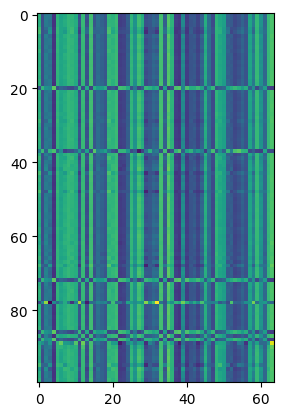

In [220]:
rbe = recommender.movie_embeddings[-100:]
plt.imshow(rbe / np.expand_dims(np.linalg.norm(rbe, axis=1), 1))

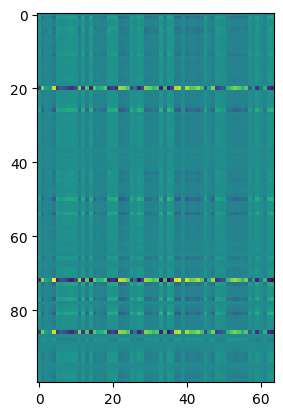

In [221]:
plt.imshow(rbe)

# Approach 3

In [233]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [246]:
pca = PCA(2)
tsne = TSNE(3)


In [247]:
pc = pca.fit_transform(barcoding)
targets = tsne.fit_transform(barcoding)

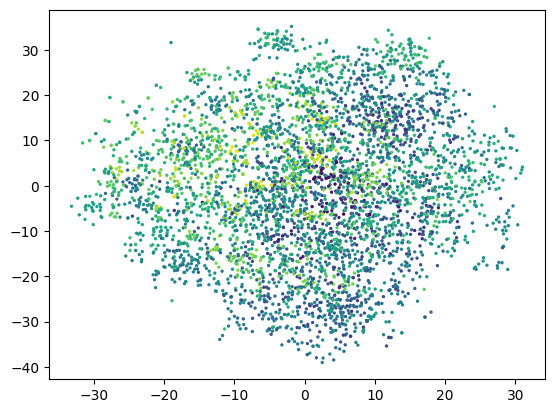

In [262]:
plt.scatter(*targets[:, :2].T, s=2, c = targets[:, 2])

In [38]:
class movie_dataset_3:
    def __init__(self, features, text, movie_ids, targets, transform= None):
        self.transform = transform
        
        self.movie_id_to_idx = {int(movie_id):idx for idx, movie_id in enumerate(movie_ids)}
        
        self.features = np.array(features)
        
        self.text, self.lengths = zip(*[self.transform(txt) for txt in text])
        self.text = np.array(self.text)
        self.lengths = np.array(self.lengths)
        
        self.targets = np.array(targets)
    def __len__(self):
        return self.targets.shape[0]
    def get_data(self, movie_id):
        idx = self.movie_id_to_idx[movie_id]
        
        return self[idx]
    def __getitem__(self, idx):
        text     = self.text[idx]
        lengths  = self.lengths[idx]
        features = self.features[idx]
        targets  = self.targets[idx]
        
        text     = torch.tensor(text)
        lengths  = torch.tensor(lengths)
        features = torch.tensor(features, dtype = torch.float32)
        targets  = torch.tensor(targets, dtype = torch.float32)
        
        return (text, features, lengths), targets

In [39]:
from sklearn.model_selection import train_test_split

(movies_data_train, movies_data_val, targets_train, targets_val, movies_plot_train, 
 movies_plot_val) = train_test_split(movies_data, targets, movies.Plot, test_size = 0.2, random_state = 1991)

NameError: name 'targets' is not defined

In [264]:
tt = TextTransformer(movies_plot_train, word_tokenize)

In [265]:
train_set = movie_dataset_3(movies_data_train, movies_plot_train, movies_plot_train.index, targets_train,
                           transform = tt)

val_set   = movie_dataset_3(movies_data_val, movies_plot_val, movies_plot_val.index, targets_val,
                           transform = tt)

In [267]:
batch_size = 50
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size = batch_size, shuffle=True)

In [269]:
net = MovieNet2(256, len(train_set.transform.vocab)+1, 128, 2, 32, 64, 3, drop_prob=0.6)

In [270]:
test_data, test_target = next(iter(train_loader))

In [273]:
net(*test_data)

tensor([[ 0.0755, -0.0491, -0.1776],
        [ 0.0848, -0.0676, -0.0910],
        [-0.0362,  0.0121, -0.0611],
        [-0.0204,  0.0530, -0.1882],
        [ 0.0669, -0.0339, -0.1210],
        [ 0.0128, -0.0554, -0.1028],
        [ 0.0665, -0.0024, -0.0448],
        [ 0.2338,  0.1809, -0.0102],
        [-0.0797,  0.0054, -0.1485],
        [-0.0436,  0.0029, -0.0588],
        [-0.0316, -0.0414, -0.1508],
        [-0.0167, -0.0724, -0.0934],
        [ 0.0405,  0.0674,  0.0055],
        [ 0.0918, -0.0177, -0.3279],
        [ 0.2183, -0.0214,  0.0477],
        [ 0.1204, -0.0578, -0.0290],
        [-0.0168, -0.0408, -0.1003],
        [-0.0235, -0.0065, -0.0669],
        [-0.0419,  0.1219, -0.1639],
        [-0.0551,  0.0551, -0.2788],
        [ 0.0508, -0.0335, -0.0653],
        [ 0.0819,  0.0246, -0.0479],
        [ 0.0371, -0.0351, -0.0945],
        [ 0.0649, -0.0316, -0.0855],
        [ 0.0600, -0.0883, -0.1196],
        [ 0.0639,  0.0764, -0.1117],
        [-0.1089, -0.0049, -0.0490],
 

In [275]:
lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.MSELoss()
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [279]:
# Clase que entrena el modelo
def train_model3(model, criterion, optimizer, train_loader, val_loader = None, epochs=8, save_criterium = "loss"):
    since = time.time()
    dataloaders = {"train":train_loader, "val":val_loader}
    device = "cuda" if train_on_gpu else "cpu"
    model.to(device)
    metric = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])
    bar_epoch = tqdm(range(epochs))
    bar_train = tqdm(range(len(train_loader)))
    best_epoch, best_crit = 0, None

    bar_epoch.set_description_str(f"Epoch 0 ")
    for epoch in range(epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            if dataloaders[phase] is not None:

                running_loss = 0.0
                running_corrects = 0
                batch_size = 0

                # Iterate over data.
                for batch, ((text, features, lengths), target) in enumerate(dataloaders[phase]):
                    target, text, features = target.to(device), text.to(device), features.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward only if phase is train
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(text, features, lengths)
                        
                        loss = criterion(outputs, target)
                        
                        if phase == 'train':
                            loss.backward() #retain_graph = True
                            optimizer.step()
                            
                            bar_train.set_description_str(f"Batch {batch} of {len(dataloaders[phase])}")
                            bar_train.update()
                    # statistics
                    running_loss += loss.item() * target.size(0)
                    batch_size += target.size(0)

                loss_value = running_loss / batch_size
                metric[phase].loss.append(loss_value)
                criterium = -loss_value

                if phase == 'val' and (best_crit is None or criterium > best_crit):
                    best_epoch, best_crit = epoch, criterium
                    torch.save(model.state_dict(), 'bestmodel.pt')

        bar_epoch.set_description_str(f"Epoch: {epoch+1} | Train Loss: {metric.train.loss[-1]:.4f} | Val Loss: \
        {metric.val.loss[-1]:.4f} | Best {save_criterium[:3]}: {best_crit:.4f}")

        bar_train.n = 0
        bar_epoch.update()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return metric, model

In [280]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [282]:

metrics_1, net = train_model3(net, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=50, save_criterium = "loss")

metrics.train.loss = metrics_1.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics_1.val.loss   + metrics_1.val.loss

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Training complete in 13m 57s


In [363]:
class Recommender:
    def __init__(self, net, movies, interactions, dataset, batch_size = 20):
        self.net = net
        self.movies = movies
        self.interactions = interactions
        self.dataset = dataset
        self.movie_embeddings = self.get_movie_embeddings(batch_size = batch_size)
    def get_movie_embeddings(self, batch_size = 20):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net.to(device)
        movie_ids = self.movies.index
        embeds = []
        bar = tqdm(range(0, len(movie_ids), batch_size))
        bar.set_description_str("Calculating movie embeddings")
        for i in range(0, len(movie_ids), batch_size):
            blabla, bleble = zip(*[self.dataset.get_data(ide) for ide in movie_ids[i:i+batch_size]])
            text, features, lengths = zip(*blabla)
            (text, features, lengths) = torch.vstack(text), torch.vstack(features), torch.hstack(lengths)
            embed = self.net(text.to(device), features.to(device), lengths)
            embeds += [embed.cpu().detach().numpy()]
            bar.update()
        return np.vstack(embeds)
    
    def get_new_embedding(self, movie_ids, mean = True):
        indexs = [self.dataset.movie_id_to_idx[movie_id] for movie_id in movie_ids]
        embeddings = self.movie_embeddings[indexs]
        return embeddings.mean(axis =0) if mean else embeddings
    
    def recommend(self, user_id = None, movie_ids = None, n = "auto", from_embedding = False):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            if from_embedding:
                embedding = self.net.users(torch.tensor(user_id).cuda()).cpu().detach().numpy()
            else:
                embedding = self.get_new_embedding(
                    self.interactions[self.interactions.userId == user_id].movieId)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            embedding = get_new_embedding(movie_ids)
            n = len(movie_ids) if n == "auto" else n
        
        similarities = cosine_similarity(embedding, self.movie_embeddings)
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def recommend2(self, user_id = None, movie_ids = None, n = "auto", sigma = 0.2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            user_embeddings = self.get_new_embedding(
                self.interactions[self.interactions.userId == user_id].movieId, mean=False)
            n = (self.interactions.userId == user_id).sum() if n == "auto" else n
        else:
            user_embeddings = self.get_new_embedding(movie_ids, mean=False)
            n = len(movie_ids) if n == "auto" else n
            
        all_movie_embeddings = np.expand_dims(self.movie_embeddings, 1)
        user_embeddings      = np.expand_dims(user_embeddings, 0)
        similarities = cosine_similarity(user_embeddings, all_movie_embeddings)
        similarities = similarities.sum(axis =-1)
        
        order = np.argsort(-similarities)
        return np.array(self.movies.index[order[:n]])
    
    def accuracy(self, user_id = None, movie_ids = None, n = "auto", method = 2):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            movie_ids = self.interactions[self.interactions.userId == user_id].movieId
        
        recommend_method = self.recommend if method ==1 else self.recommend2
        recommendations = recommend_method(user_id = user_id, movie_ids = movie_ids, n=n)
        return len(set(recommendations).intersection(set(movie_ids))) / len(set(recommendations))

In [310]:
recommender = Recommender(net, movies_plot_train, interactions, train_set)

  0%|          | 0/190 [00:00<?, ?it/s]

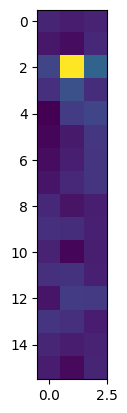

In [311]:
plt.imshow(recommender.movie_embeddings[-16:])

# Approach 4

In [27]:
def cosine_similarity(x, y, smooth = True):
    dot = np.sum(x*y, axis = -1)
    norm = (np.linalg.norm(x, axis=-1) * np.linalg.norm(y, axis=-1)) + 1e-320 if smooth else 0
    return dot/norm

In [28]:
class PairLoader:
    def __init__(self, dataset, batch_size = 10, zerois =0):
        self.dataset = dataset
        self.barcode = dataset.barcode
        self.batch_size = batch_size
        self.zerois = zerois
    
    def __len__(self):
        return int((len(self.dataset) // 2) // self.batch_size)
        
    def __iter__(self):
        self.index = 0
        self.order = np.argsort(np.random.randn(len(self.dataset)))
        self.index_order = self.order[:2*(len(self.order)//2)].reshape(-1, 2)
        return self
    
    def __next__(self):
        if self.index < len(self.index_order):
            
            indexs = self.index_order[self.index : self.index + self.batch_size]
            
            barcode1 = self.barcode[indexs[:, 0]]
            barcode2 = self.barcode[indexs[:, 1]]
            
            barcode1 = np.where(barcode1 ==0, self.zerois, barcode1)
            barcode2 = np.where(barcode2 ==0, self.zerois, barcode2)
            
            cosines = cosine_similarity(barcode1, barcode2)
            
            indexs = indexs.T.flatten()
            data = self.dataset[indexs]
            
            self.index += self.batch_size
            return (data, torch.tensor(cosines, dtype = torch.float32))
        else:
            raise StopIteration

In [29]:
# Clase que entrena el modelo
def train_model4(model, criterion, optimizer, train_loader, val_loader = None, epochs=8, save_criterium = "loss"):
    since = time.time()
    dataloaders = {"train":train_loader, "val":val_loader}
    device = "cuda" if train_on_gpu else "cpu"
    model.to(device)
    metric = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])
    bar_epoch = tqdm(range(epochs))
    bar_train = tqdm(range(len(train_loader)))
    best_epoch, best_crit = 0, None
    
    cos = nn.CosineSimilarity()

    bar_epoch.set_description_str(f"Epoch 0 ")
    for epoch in range(epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            if dataloaders[phase] is not None:

                running_loss = 0.0
                running_corrects = 0
                batch_size = 0

                # Iterate over data.
                for batch, ((text, features, lengths), target) in enumerate(dataloaders[phase]):
                    target, text, features = target.to(device), text.to(device), features.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward only if phase is train
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(text, features, lengths)
                        out1, out2 = outputs[: len(outputs)//2], outputs[len(outputs)//2:]
                        
                        similarity = cos(out1, out2)
                        loss = criterion(similarity, target)
                        
                        if phase == 'train':
                            loss.backward() #retain_graph = True
                            optimizer.step()
                            
                            bar_train.set_description_str(f"Batch {batch} of {len(dataloaders[phase])}")
                            bar_train.update()
                    # statistics
                    running_loss += loss.item() * target.size(0)
                    batch_size += target.size(0)

                loss_value = running_loss / batch_size
                metric[phase].loss.append(loss_value)
                criterium = -loss_value

                if phase == 'val' and (best_crit is None or criterium > best_crit):
                    best_epoch, best_crit = epoch, criterium
                    torch.save(model.state_dict(), 'bestmodel.pt')

        bar_epoch.set_description_str(f"Epoch: {epoch+1} | Train Loss: {metric.train.loss[-1]:.4f} | Val Loss: \
        {metric.val.loss[-1]:.4f} | Best {save_criterium[:3]}: {best_crit:.4f}")

        bar_train.n = 0
        bar_epoch.update()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return metric, model

In [30]:
class MovieNet2(nn.Module):
    def __init__(self, embedding_dim, vocab_size, lstm_dim, lstm_layers, n_features, 
                 hidden_dim, output_dim, drop_prob=0.2, bidirectional = False):
        
        super(MovieNet2, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, lstm_dim, lstm_layers,
                            dropout=drop_prob, batch_first=True, bidirectional = bidirectional)

        self.dropout = nn.Dropout(drop_prob)
        
        # Capas lineales y salida
        self.fc1 = nn.Linear(lstm_dim*(1+bidirectional) + n_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.fun = nn.ReLU()

    def forward(self, text, features, lengths):
        
        x = self.embedding(text)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = False)
        x, _ = self.lstm(x)
        x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first = True)   
        
        #Tomamos solo el último valor de salida del LSTM
        x = x[:,-1,:]
        
        # Concatenamos con features
        x = torch.hstack((x, features))
        x = self.dropout(x)
        
        # Capas finales y salida
        x = self.fc1(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [31]:
class Metrics:
    def __init__(self, keys):
        self.data = {key: Metrics(keys[1:]) if len(keys)>1 else [] for key in keys[0]}
        self.__dict__.update(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def dataframe(self):
        def rec(metric, name):
            if isinstance(metric, Metrics):
                ret = {key: rec(metric[key], key) for key in metric.data}
                if type(list(ret.values())[0]) is list:
                    return {name+"_"+k:ret[k] for k in ret}
                return {name+"_"+subkey:ret[key][subkey] for key in ret for subkey in ret[key]}
            else:
                return metric
        data = rec(self, "")
        return pd.DataFrame({key[1:]:data[key] for key in data})

In [33]:
def interaction_matrix(interactions, movies):
    out = pd.DataFrame(0, columns = interactions.userId.unique(), index = movies.index)
    for row in interactions.iloc[:, :2].to_numpy():
        out.loc[row[1], row[0]]+=1
    return out

In [34]:
barcoding = interaction_matrix(interactions_train, movies)

In [35]:
barcoding.shape

(4750, 530)

In [43]:
movies_data = ct.fit_transform(movies)

In [44]:
from sklearn.model_selection import train_test_split

(movies_data_train, movies_data_val, barcoding_train, barcoding_val, movies_plot_train, 
 movies_plot_val) = train_test_split(movies_data, barcoding, movies.Plot, test_size = 0.2, random_state = 1991)

In [45]:
tt = TextTransformer(movies_plot_train, word_tokenize)

In [48]:
train_set = movie_dataset_2(movies_data_train, movies_plot_train, movies_plot_train.index, barcoding_train,
                           transform = tt)

val_set   = movie_dataset_2(movies_data_val, movies_plot_val, movies_plot_val.index, barcoding_val,
                           transform = tt)

In [49]:
train_loader = PairLoader(train_set, batch_size = 25)
val_loader   = PairLoader(val_set,   batch_size = 25)

### Modelo 1

In [714]:
net1 = MovieNet2(256, len(train_set.transform.vocab)+1, 128, 2, 32, 64, 32, drop_prob=0.6)

In [715]:
test_data, test_target = next(iter(val_loader))

In [720]:
net1(*test_data)

tensor([[ 0.0838,  0.0406, -0.1849,  ..., -0.1532,  0.0834, -0.1559],
        [-0.0882,  0.0483, -0.1541,  ...,  0.0063,  0.1141, -0.1099],
        [-0.0380,  0.0279, -0.1585,  ..., -0.0840,  0.0874, -0.0514],
        ...,
        [-0.0700, -0.0609, -0.0892,  ..., -0.0050, -0.0669,  0.2565],
        [-0.0017,  0.0703, -0.1727,  ..., -0.1577,  0.0172, -0.1329],
        [ 0.0066,  0.1674, -0.1819,  ..., -0.1461,  0.0652,  0.0199]],
       grad_fn=<AddmmBackward0>)

In [721]:
lr = 0.001
optimizer = torch.optim.Adam(net1.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.MSELoss()
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [478]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [484]:

metrics_1, net1 = train_model4(net1, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=150, save_criterium = "loss")

metrics.train.loss = metrics_1.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics_1.val.loss   + metrics_1.val.loss

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Training complete in 51m 6s


In [724]:
net1.load_state_dict(torch.load("bestmodel_3_2.pt"))

<All keys matched successfully>

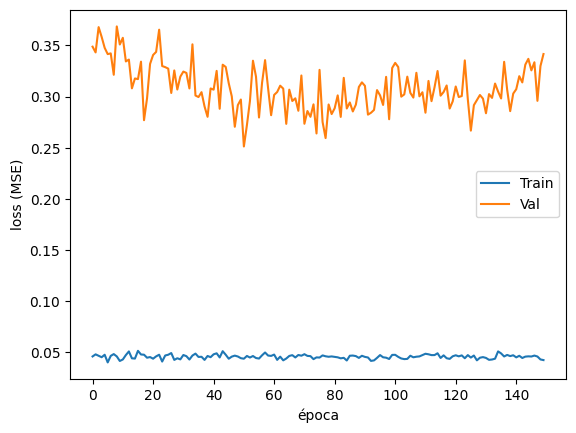

In [485]:
plt.plot(metrics_1.train.loss, label="Train")
plt.plot(metrics_1.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

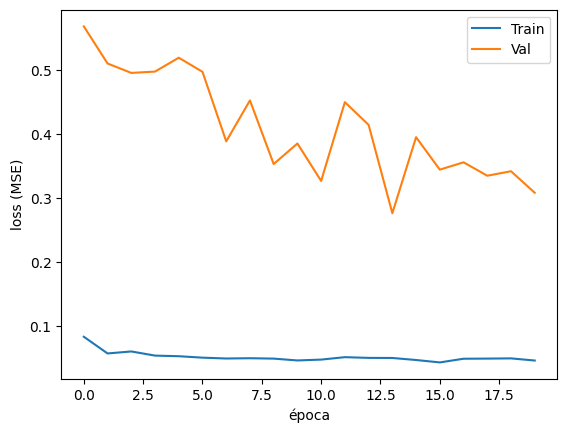

In [359]:
plt.plot(metrics_1.train.loss, label="Train")
plt.plot(metrics_1.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

In [725]:
full_set = val_set.cat(train_set)

In [147]:
class Recommender:
    def __init__(self, net, interactions, dataset, batch_size = 20):
        self.net = net
        self.interactions = interactions
        self.dataset = dataset
        self.movie_ids = dataset.movie_ids
        self.movie_embeddings = self.get_movie_embeddings(batch_size = batch_size)
    def get_movie_embeddings(self, batch_size = 20):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net.to(device)
        movie_ids = self.movie_ids
        embeds = []
        bar = tqdm(range(0, len(movie_ids), batch_size))
        bar.set_description_str("Calculating movie embeddings")
        for i in range(0, len(movie_ids), batch_size):
            text, features, lengths = self.dataset[i:i+batch_size]
            embed = self.net(text.to(device), features.to(device), lengths)
            embeds += [embed.cpu().detach().numpy()]
            bar.update()
        return np.vstack(embeds)
    
    def get_new_embedding(self, movie_ids, mean = True):
        indexs = [self.dataset.movie_id_to_idx[movie_id] for movie_id in movie_ids]
        embeddings = self.movie_embeddings[indexs]
        return embeddings.mean(axis =0) if mean else embeddings
    
    def recommend(self, user_id = None, movie_ids = None, from_embedding=None, n = "auto", 
                  sigma = 0.2, mean = False, include_input = False):
        assert not (user_id is None and movie_ids is None and from_embedding is None), "Either specify a user_id or a list of movie_ids"
        if from_embedding is None:
            if user_id is not None:
                movie_ids = self.interactions[self.interactions.userId == user_id].movieId
            user_embeddings = self.get_new_embedding(movie_ids, mean=mean)
            n = len(movie_ids) if n == "auto" else n
        else:
            user_embeddings = from_embedding

        all_movie_embeddings = np.expand_dims(self.movie_embeddings, 1)
        user_embeddings      = np.expand_dims(user_embeddings, 0)
        similarities = cosine_similarity(user_embeddings, all_movie_embeddings)
        similarities = np.exp( -(1 - similarities)**2 / (2*sigma**2))
        similarities = similarities.sum(axis =-1)

        order = np.argsort(-similarities)
        all_movie_ids = self.movie_ids.copy()[order]
        if (not include_input) and from_embedding is None:
            all_movie_ids = all_movie_ids[~np.isin(all_movie_ids, movie_ids)]
        return np.array(all_movie_ids[:n])

    def accuracy(self, user_id = None, movie_ids = None, sigma = 0.2, 
                 mean = False, include_input= False, input_ratio = 0.5):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            movie_ids = self.interactions[self.interactions.userId == user_id].movieId
        movie_ids = np.array(movie_ids)
        movie_ids_in = np.random.choice(movie_ids, int(len(movie_ids)*input_ratio), replace= False)
        if include_input:
            movie_ids_target = movie_ids.copy()
        else: 
            movie_ids_target = movie_ids[~np.isin(movie_ids, movie_ids_in)]
        
        recommendations = self.recommend(movie_ids = movie_ids_in, n=len(movie_ids_target),
                                         sigma=sigma, mean = mean, include_input = include_input)
        return len(set(recommendations).intersection(set(movie_ids_target))) / len(set(recommendations))
    

In [728]:
recommender = Recommender(net1, interactions, full_set, batch_size = 50)

  0%|          | 0/95 [00:00<?, ?it/s]

In [734]:
recommender.accuracy(1, include_input = True, sigma = 0.2, input_ratio = 1.0)

0.9032258064516129

In [737]:
np.mean([recommender.accuracy(user_id, sigma = 0.1, include_input = False, input_ratio = 0.1) 
         for user_id in range(1,100)])

0.019524111115711458

In [504]:
embeds.min()

-3.5029297

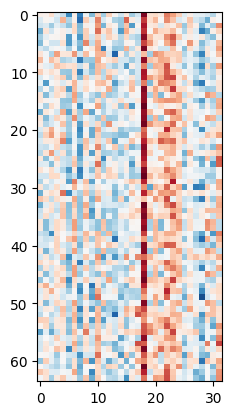

In [507]:
embeds = recommender.movie_embeddings[-64:]
embeds = embeds / np.linalg.norm([embeds], axis = 2).T
rg = max(-embeds.min(), embeds.max())
plt.imshow(embeds, cmap = "RdBu", vmin = -rg, vmax = rg)
#plt.imshow(embeds)

In [517]:
allsims = np.zeros((len(recommender.movie_embeddings), len(recommender.movie_embeddings)))
for i, embed in enumerate(recommender.movie_embeddings):
    allsims[i] = cosine_similarity(embed, recommender.movie_embeddings)

In [523]:
(allsims.flatten() <0 ).sum()/ (len(allsims)**2)

0.0002811745152354571

(array([1.278000e+03, 1.917800e+04, 7.020400e+04, 1.900580e+05,
        4.479980e+05, 1.348382e+06, 2.137632e+06, 1.989580e+06,
        1.800578e+06, 1.808604e+06, 1.729880e+06, 1.729880e+06,
        1.742162e+06, 1.721976e+06, 1.612456e+06, 1.328028e+06,
        1.052642e+06, 8.167440e+05, 4.635420e+05, 5.516980e+05]),
 array([-0.07717411, -0.0233154 ,  0.03054331,  0.08440202,  0.13826073,
         0.19211945,  0.24597816,  0.29983687,  0.35369558,  0.40755429,
         0.461413  ,  0.51527172,  0.56913043,  0.62298914,  0.67684785,
         0.73070656,  0.78456527,  0.83842398,  0.8922827 ,  0.94614141,
         1.00000012]),
 <BarContainer object of 20 artists>)

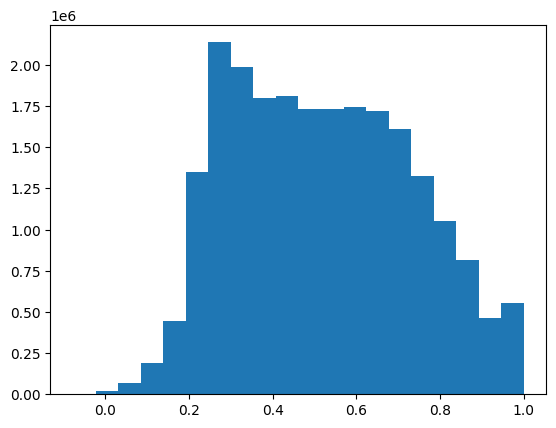

In [525]:
plt.hist(allsims.flatten(), bins = 20)

In [491]:
from sklearn.decomposition import PCA

pca = PCA(3)

In [497]:
lowdim = pca.fit_transform(recommender.movie_embeddings)

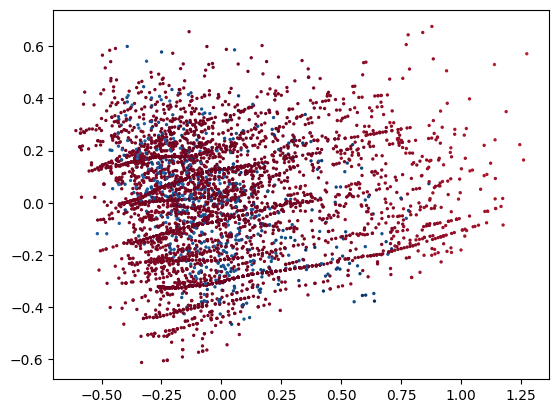

In [508]:
plt.scatter(*lowdim[:, 1:].T, s = 2, c = lowdim[:, 0], cmap = "RdBu")

### Modelo 2

In [50]:
def similarity(x, y):
    return (x == y).sum(-1) / x.shape[-1]

In [51]:
def similarity2(x, y, weights):
    return np.sum([((x == v) & (y==v)).sum(-1) * weights[v] / x.shape[-1] for v in weights], axis=0)

In [52]:
a = np.array([1,0,0])
b = np.array([[1,1,0], [0,0,1]])

similarity2(a,b, {1:10,0:2})

array([4.        , 0.66666667])

In [53]:
class PairLoader2:
    def __init__(self, dataset, batch_size = 10, midpoint = "mean", pretrained = None):
        self.dataset = dataset
        self.barcode = dataset.barcode
        self.batch_size = batch_size
        self.midpoint = midpoint
        self.weights = {i:(1-(self.barcode == i).sum()/self.barcode.size) 
                        for i in (0,1)} if pretrained is None else pretrained.weights
        self.calculate_ranges(pretrained)
    def __len__(self):
        return int((len(self.dataset) // 2) // self.batch_size)
    
    def calculate_ranges(self, pretrained):
        if pretrained is None:
            self.similarity = np.zeros((len(self.barcode), len(self.barcode)))
            bar = tqdm(range(len(self.barcode)))
            for i in range(len(self.barcode)):
                self.similarity[i] = similarity2(self.barcode[i], self.barcode, self.weights)
                bar.update()
        else:
            self.similarity = pretrained.similarity
        sim_flat = self.similarity.copy()
        sim_flat[np.identity(sim_flat.shape[0]) == 1] = np.nan
        sim_flat = sim_flat.flatten()
        sim_flat = sim_flat[~ np.isnan(sim_flat)]
        self.mean   = sim_flat.mean()
        self.median = np.median(sim_flat)
        self.max    = sim_flat.max()
        self.min    = sim_flat.min()
        
    def __iter__(self):
        self.index = 0
        self.order = np.argsort(np.random.randn(len(self.dataset)))
        self.index_order = self.order[:2*(len(self.order)//2)].reshape(-1, 2)
        return self
    
    def __next__(self):
        if self.index < len(self.index_order):
            
            indexs = self.index_order[self.index : self.index + self.batch_size]
            
            barcode1 = self.barcode[indexs[:, 0]]
            barcode2 = self.barcode[indexs[:, 1]]
            
            midpoint = self.mean if self.midpoint == "mean" else self.median
            sims = similarity2(barcode1, barcode2, weights = self.weights)
            sims = np.where(sims < midpoint, (sims - midpoint) / (midpoint - self.min), 
                            (sims - midpoint) / (self.max - midpoint))
            
            indexs = indexs.T.flatten()
            data = self.dataset[indexs]
            
            self.index += self.batch_size
            return (data, torch.tensor(sims, dtype = torch.float32))
        else:
            raise StopIteration

In [54]:
train_loader = PairLoader2(train_set, batch_size = 25)
val_loader   = PairLoader2(val_set,   batch_size = 25, pretrained = train_loader)

  0%|          | 0/3800 [00:00<?, ?it/s]

In [55]:
class MovieNet3( MovieNet2):
    def __init__(self, embedding_dim, vocab_size, lstm_dim, lstm_layers, n_features, 
                 hidden_dim, output_dim, drop_prob=0.2, bidirectional = False):
        
        super(MovieNet3, self).__init__(embedding_dim, vocab_size, lstm_dim, lstm_layers, n_features, 
                 hidden_dim, output_dim, drop_prob=drop_prob, bidirectional = bidirectional)

    def forward(self, text, features, lengths):
        x = self.embedding(text)
        x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first = True, enforce_sorted = False)
        x, _ = self.lstm(x)
        x, lengths = nn.utils.rnn.pad_packed_sequence(x, batch_first = True)   
        
        #Tomamos solo el último valor de salida del LSTM
        x = x[:,-1,:]
        
        # Concatenamos con features
        x = torch.hstack((x, features))
        x = self.dropout(x)
        
        # Capas finales y salida
        x = self.fc1(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [1516]:
net2 = MovieNet3(256, len(train_set.transform.vocab)+1, 128, 2, 32, 128, 16, drop_prob=0.4)

In [739]:
test_data, test_target = next(iter(val_loader))

In [740]:
net2(*test_data).shape

torch.Size([50, 16])

In [691]:
lr = 0.0002
optimizer = torch.optim.Adam(net2.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.MSELoss()
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [692]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [693]:

metrics_1, net2 = train_model4(net2, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=50, save_criterium = "loss")

metrics.train.loss = metrics.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics.val.loss   + metrics_1.val.loss

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Training complete in 14m 5s


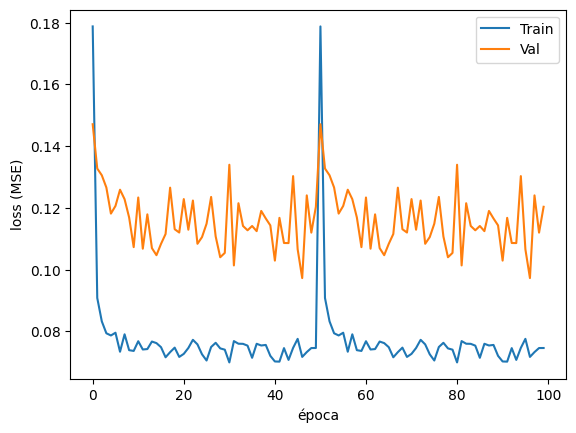

In [695]:
plt.plot(metrics.train.loss, label="Train")
plt.plot(metrics.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

In [1517]:
net2.load_state_dict(torch.load("bestmodel_4_1.pt"))

<All keys matched successfully>

In [149]:
full_set = val_set.cat(train_set)

In [150]:
recommender = Recommender(net2, interactions, full_set, batch_size = 50)

  0%|          | 0/95 [00:00<?, ?it/s]

In [1525]:
len(tt.vocab)*2

60810

In [1523]:
net2

MovieNet3(
  (embedding): Embedding(60171, 256, padding_idx=0)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
  (fun): ReLU()
)

In [758]:
np.mean([recommender.accuracy(user_id, sigma = 0.1, include_input = True, input_ratio = 1.0) 
         for user_id in range(1,100)])

0.9983763166786241

In [767]:
np.mean([recommender.accuracy(user_id, sigma = 0.5, include_input = False, input_ratio = 0.5) 
         for user_id in range(1,611)])

0.015905845377091353

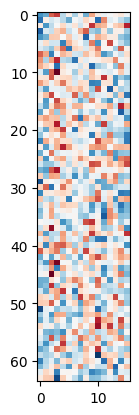

In [707]:
embeds = recommender.movie_embeddings[-64:]
embeds = embeds / np.linalg.norm([embeds], axis = 2).T
rg = max(-embeds.min(), embeds.max())
plt.imshow(embeds, cmap = "RdBu", vmin = -rg, vmax = rg)
#plt.imshow(embeds)

In [709]:
allsims = np.zeros((len(recommender.movie_embeddings), len(recommender.movie_embeddings)))
for i, embed in enumerate(recommender.movie_embeddings):
    allsims[i] = cosine_similarity(embed, recommender.movie_embeddings)

(array([2.220000e+02, 2.178000e+03, 9.504000e+03, 4.276800e+04,
        1.261060e+05, 2.233580e+05, 3.848240e+05, 6.083980e+05,
        8.750400e+05, 1.184712e+06, 1.478002e+06, 1.719134e+06,
        1.921200e+06, 1.979414e+06, 1.905762e+06, 1.742888e+06,
        1.561692e+06, 1.348272e+06, 1.127210e+06, 9.284340e+05,
        7.727180e+05, 6.236940e+05, 5.055700e+05, 4.393780e+05,
        3.398900e+05, 2.179120e+05, 1.487520e+05, 1.172460e+05,
        7.706600e+04, 1.511560e+05]),
 array([-0.88057125, -0.81788553, -0.75519982, -0.69251411, -0.6298284 ,
        -0.56714269, -0.50445697, -0.44177126, -0.37908555, -0.31639984,
        -0.25371412, -0.19102841, -0.1283427 , -0.06565699, -0.00297128,
         0.05971444,  0.12240015,  0.18508586,  0.24777157,  0.31045729,
         0.373143  ,  0.43582871,  0.49851442,  0.56120013,  0.62388585,
         0.68657156,  0.74925727,  0.81194298,  0.87462869,  0.93731441,
         1.00000012]),
 <BarContainer object of 30 artists>)

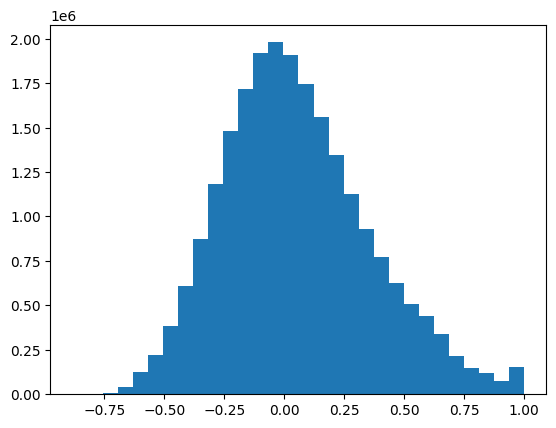

In [710]:
plt.hist(allsims.flatten(), bins = 30)

### Modelo 3

In [780]:
net3 = MovieNet2(128, len(train_set.transform.vocab)+1, 64, 2, 32, 96, 16, drop_prob=0.5)

In [781]:
train_loader = PairLoader(train_set, batch_size = 25)
val_loader   = PairLoader(val_set,   batch_size = 25)

In [782]:
lr = 0.0001
optimizer = torch.optim.Adam(net3.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.MSELoss()
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [783]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [784]:

metrics_1, net3 = train_model4(net3, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=50, save_criterium = "loss")

metrics.train.loss = metrics.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics.val.loss   + metrics_1.val.loss

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Training complete in 10m 27s


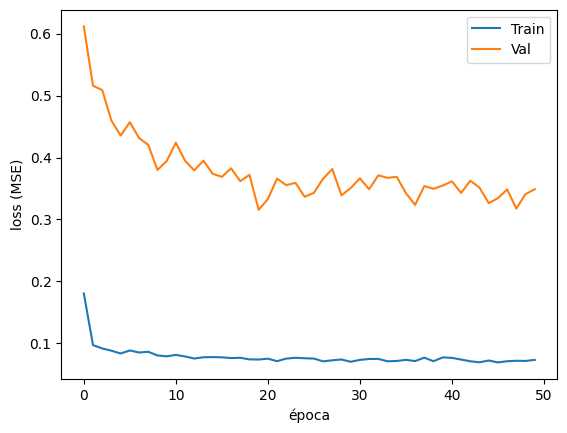

In [785]:
plt.plot(metrics.train.loss, label="Train")
plt.plot(metrics.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

In [786]:
net3.load_state_dict(torch.load("bestmodel_5_1.pt"))

<All keys matched successfully>

In [788]:
full_set = val_set.cat(train_set)
recommender = Recommender(net3, interactions, full_set, batch_size = 50)

  0%|          | 0/95 [00:00<?, ?it/s]

In [794]:
np.mean([recommender.accuracy(user_id, sigma = 0.001, include_input = True, input_ratio = 1.0) 
         for user_id in range(1,100)])

0.33558153479936076

In [793]:
np.mean([recommender.accuracy(user_id, sigma = 0.2, include_input = False, input_ratio = 0.5) 
         for user_id in range(1,100)])

0.02351426761663057

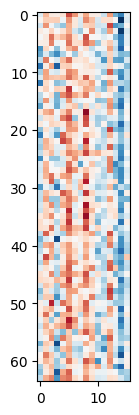

In [795]:
embeds = recommender.movie_embeddings[-64:]
embeds = embeds / np.linalg.norm([embeds], axis = 2).T
rg = max(-embeds.min(), embeds.max())
plt.imshow(embeds, cmap = "RdBu", vmin = -rg, vmax = rg)
#plt.imshow(embeds)

In [796]:
allsims = np.zeros((len(recommender.movie_embeddings), len(recommender.movie_embeddings)))
for i, embed in enumerate(recommender.movie_embeddings):
    allsims[i] = cosine_similarity(embed, recommender.movie_embeddings)

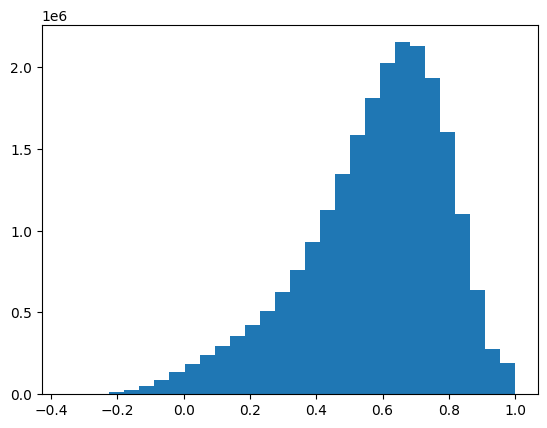

In [797]:
plt.hist(allsims.flatten(), bins = 30)
pass

### Modelo 4

In [1346]:
net4 = MovieNet3(256, len(train_set.transform.vocab)+1, 128, 2, 32, 128, 32, drop_prob=0.2)

In [1342]:
train_loader = PairLoader2(train_set, batch_size = 25, midpoint = "median")
val_loader   = PairLoader2(val_set,   batch_size = 25, pretrained = train_loader, midpoint = "median")

  0%|          | 0/3800 [00:00<?, ?it/s]

In [1351]:
lr = 0.0002
optimizer = torch.optim.Adam(net4.parameters(), lr=lr) #weight_decay = 0.0001
criterion = nn.MSELoss()
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [1352]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics4 = Metrics([["train", "val"], ["accuracy", "loss", "f1"]])

In [1355]:

metrics_1, net4 = train_model4(net4, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=10, save_criterium = "loss")

metrics4.train.loss = metrics4.train.loss + metrics_1.train.loss
metrics4.val.loss   = metrics4.val.loss   + metrics_1.val.loss

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Training complete in 2m 47s


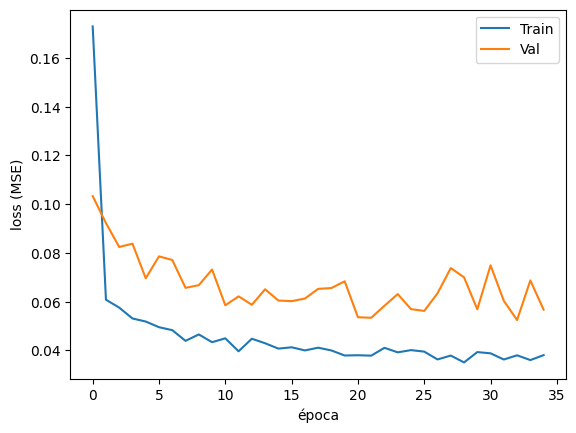

In [1356]:
plt.plot(metrics4.train.loss, label="Train")
plt.plot(metrics4.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

In [1358]:
net4.load_state_dict(torch.load("bestmodel_6_1.pt"))

<All keys matched successfully>

In [1362]:
recommender4 = Recommender2(net4, unet, interactions, full_set, train_loader, batch_size = 50)

  0%|          | 0/95 [00:00<?, ?it/s]

# User Embeddings

In [656]:
class UserNet(nn.Module):
    def __init__(self, input_dim, user_embedding_dim, movie_embedding_dim,
                 hidden_dim_1, hidden_dim_2, drop_prob=0.2):
        
        super(UserNet, self).__init__()
        
        self.fc_in_1    = nn.Linear(input_dim,    hidden_dim_1)
        self.fc_in_2    = nn.Linear(hidden_dim_1, user_embedding_dim)
        self.fc_out_1   = nn.Linear(user_embedding_dim + movie_embedding_dim, hidden_dim_2)
        self.fc_out_2   = nn.Linear(hidden_dim_2, 1)

        self.dropout = nn.Dropout(drop_prob)
        
        self.fun = nn.ReLU()
        
    def embed(self, x):
        #x = self.dropout(x)
        x = self.fc_in_1(x)
        x = self.fun(x)
        x = self.dropout(x)
        return self.fc_in_2(x)
    
    def likeliness(self, user_input, movie_embeddings):
        user_input = torch.tile(user_input.unsqueeze(1), (movie_embeddings.shape[0], 1))
        movie_embeddings = torch.tile(movie_embeddings.unsqueeze(0), (user_input.shape[0], 1, 1))
        x = torch.cat((movie_embeddings, user_input), 2)
        
        x = self.dropout(x)
        x = self.fc_out_1(x)
        x = self.fun(x)
        x = self.dropout(x)
        x = self.fc_out_2(x).squeeze()
        return torch.sigmoid(x)

    def forward(self, user_input, movie_embeddings):
        user_input = self.embed(user_input)
        return self.likeliness(user_input, movie_embeddings)
        

In [657]:
class UserLoader:
    def __init__(self, users_barcoding, movie_barcoding, movie_embeddings, batch_size = 10, movie_batch_ratio = 0.1):
        self.users_barcoding = users_barcoding
        self.movie_barcoding = movie_barcoding
        self.movie_embeddings = movie_embeddings
        self.batch_size = batch_size
        self.movie_batch_size = int(movie_batch_ratio * movie_embeddings.shape[0])
        self.reset_movie_batch()
    def reset_movie_batch(self):
        self.movie_index = 0
        self.movie_order = np.random.choice(np.arange(self.movie_embeddings.shape[0]), replace = False,
                                          size = self.movie_embeddings.shape[0])
    def next_movies(self):
        order = self.movie_order[self.movie_index: self.movie_index + self.movie_batch_size]
        self.movie_index += self.movie_batch_size
        if self.movie_index >= self.movie_embeddings.shape[0]:
            self.reset_movie_batch()
        return order
    
    def __len__(self):
        return int(self.users_barcoding.shape[1] // self.batch_size)
    def __iter__(self):
        self.user_index = 0
        self.user_order = np.random.choice(np.arange(self.users_barcoding.shape[1]), replace = False,
                                          size = self.users_barcoding.shape[1])
        return self
    
    def __next__(self):
        if self.user_index < self.users_barcoding.shape[1]:
            user_order  = self.user_order[self.user_index: self.user_index + self.batch_size]
            movie_order = self.next_movies()
            
            user_data  = self.users_barcoding.iloc[:, user_order].to_numpy().T
            movie_data = self.movie_embeddings[movie_order]
            target     = self.movie_barcoding.iloc[movie_order, user_order].to_numpy().T
            
            user_data  = torch.tensor(user_data,  dtype = torch.float32)
            movie_data = torch.tensor(movie_data, dtype = torch.float32)
            target     = torch.tensor(target,     dtype = torch.float32)
            
            self.user_index += self.batch_size
            
            return user_data, movie_data, target
        else:
            raise StopIteration

In [1156]:
# Clase que entrena el modelo
def train_model5(model, criterion, optimizer, train_loader, val_loader = None, epochs=8, save_criterium = "loss"):
    since = time.time()
    dataloaders = {"train":train_loader, "val":val_loader}
    device = "cuda" if train_on_gpu else "cpu"
    model.to(device)
    metric = Metrics([["train", "val"], ["accuracy", "loss", "k_acc"]])
    bar_epoch = tqdm(range(epochs))
    bar_train = tqdm(range(len(train_loader)))
    best_epoch, best_crit = 0, None

    bar_epoch.set_description_str(f"Epoch 0 ")
    for epoch in range(epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            if dataloaders[phase] is not None:

                running_loss = 0.0
                running_corrects = 0
                running_k_acc = 0.0
                batch_size = 0
                num_elements = 0

                # Iterate over data.
                for batch, (users, movies, target) in enumerate(dataloaders[phase]):
                    users, movies, target = users.to(device), movies.to(device), target.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward only if phase is train
                    with torch.set_grad_enabled(phase == 'train'):

                        output = model(users, movies)
                        
                        loss = criterion(output, target)
                        corrects  = ((output> 0.5)*1 == target).sum()
                        thresh = torch.sort(output, descending=True).values[
                            range(len(output)), target.sum(-1, dtype=int)-1].unsqueeze(-1)
                        k_acc = (((output >=thresh) & (target==1)).sum(-1) / target.sum(-1))
                        k_acc = k_acc[~torch.isnan(k_acc)].mean().item()

                        if phase == 'train':
                            loss.backward() #retain_graph = True
                            optimizer.step()
                            
                            bar_train.set_description_str(f"Batch {batch} of {len(dataloaders[phase])}")
                            bar_train.update()
                    # statistics
                    running_loss += loss.item() * target.size(0)
                    running_corrects  += corrects.item()
                    running_k_acc += 0.5 * target.size(0) if np.isnan(k_acc) else k_acc * target.size(0)
                    batch_size += target.size(0)
                    num_elements += target.numel()
                
                loss_value = running_loss / batch_size
                k_acc_value = running_k_acc / batch_size
                acc_value  = running_corrects / num_elements
                metric[phase].loss.append(loss_value)
                metric[phase].accuracy.append(acc_value)
                metric[phase].k_acc.append(k_acc_value)
                criterium = {"loss": -loss_value, "accuracy": acc_value, "k_acc":k_acc_value}[save_criterium]
                if phase == 'val' and (best_crit is None or criterium > best_crit):
                    best_epoch, best_crit = epoch, criterium
                    torch.save(model.state_dict(), 'bestmodel.pt')

        bar_epoch.set_description_str(f"Epoch: {epoch+1} | Train Loss: {metric.train.loss[-1]:.4f} \
        K_Acc: {metric.train.k_acc[-1]:.4f} | Val Loss: {metric.val.loss[-1]:.4f} K_Acc: \
        {metric.val.k_acc[-1]:.4f}| Best {save_criterium[:3]}: {best_crit:.4f}")

        bar_train.n = 0
        bar_epoch.update()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return metric, model

### Modelo 2

In [1157]:
from sklearn.model_selection import train_test_split

(barcoding_train, barcoding_val, movie_embeddings_train, movie_embeddings_val) = train_test_split(
    barcoding.loc[recommender.movie_ids], recommender.movie_embeddings, test_size = 0.1, random_state = 1991)

In [1158]:
train_loader = UserLoader(barcoding, barcoding_train, movie_embeddings_train, 
                          batch_size = 50, movie_batch_ratio = 0.26)
val_loader   = UserLoader(barcoding, barcoding_val,   movie_embeddings_val,   
                          batch_size = 50, movie_batch_ratio = 1.0)

In [1159]:
unet = UserNet(barcoding.shape[0], 16, 16, 128, 32, drop_prob = 0.0)
unet = UserNet(barcoding.shape[0], 64, 16, 256, 64, drop_prob = 0.0)

In [1645]:
unet4

UserNet(
  (fc_in_1): Linear(in_features=4750, out_features=256, bias=True)
  (fc_in_2): Linear(in_features=256, out_features=64, bias=True)
  (fc_out_1): Linear(in_features=96, out_features=128, bias=True)
  (fc_out_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fun): ReLU()
)

In [1160]:
test_data = next(iter(train_loader))

In [1161]:
unet(test_data[0], test_data[1])

tensor([[0.4866, 0.4838, 0.4851,  ..., 0.4844, 0.4847, 0.4850],
        [0.4899, 0.4879, 0.4889,  ..., 0.4885, 0.4883, 0.4890],
        [0.4840, 0.4819, 0.4831,  ..., 0.4831, 0.4823, 0.4838],
        ...,
        [0.4863, 0.4837, 0.4846,  ..., 0.4844, 0.4841, 0.4850],
        [0.4894, 0.4875, 0.4882,  ..., 0.4882, 0.4876, 0.4887],
        [0.4877, 0.4858, 0.4867,  ..., 0.4864, 0.4859, 0.4871]],
       grad_fn=<SigmoidBackward0>)

In [1162]:
class WBCELoss:
    def __init__(self, pos_weight):
        self.pos_weight = pos_weight
        
    def __call__(self, output, target):
        loss = self.pos_weight * (target * torch.log(output)) + ((1 - target) * torch.log(1 - output))

        return -torch.mean(loss)

In [1163]:
lr = 0.001
optimizer = torch.optim.Adam(unet.parameters(), lr=lr) #weight_decay = 0.0001
criterion = WBCELoss(50)
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [1164]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics = Metrics([["train", "val"], ["accuracy", "loss", "k_acc"]])

In [1174]:

metrics_1, unet = train_model5(unet, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=1000, save_criterium = "k_acc")

metrics.train.loss = metrics.train.loss + metrics_1.train.loss
metrics.val.loss   = metrics.val.loss   + metrics_1.val.loss
metrics.train.accuracy = metrics.train.accuracy + metrics_1.train.accuracy
metrics.val.accuracy   = metrics.val.accuracy   + metrics_1.val.accuracy
metrics.train.k_acc = metrics.train.data["k_acc"] + metrics_1.train.k_acc
metrics.val.k_acc   = metrics.val.data["k_acc"]   + metrics_1.val.k_acc

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 5m 23s


AttributeError: 'Metrics' object has no attribute 'k_acc'

In [1176]:
torch.save(unet.state_dict(), 'user_net.pt')

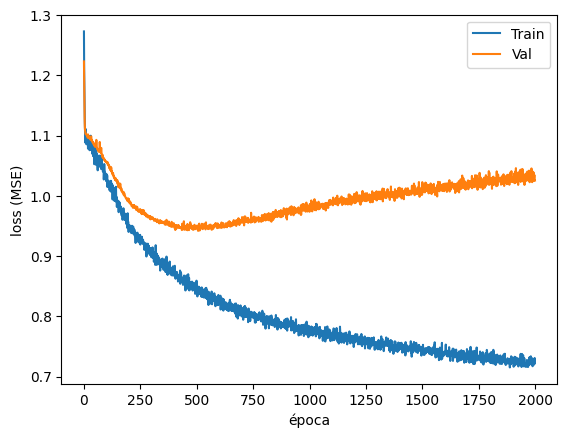

In [1177]:
plt.plot(metrics.train.loss, label="Train")
plt.plot(metrics.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

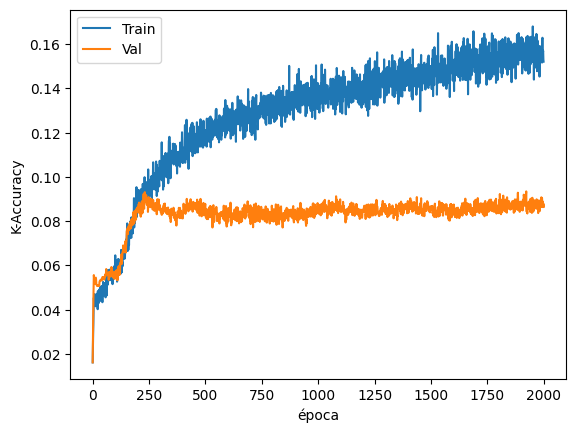

In [1179]:
plt.plot(metrics.train.k_acc, label="Train")
plt.plot(metrics.val.k_acc, label="Val")
plt.xlabel("época")
plt.ylabel("K-Accuracy")
plt.legend()

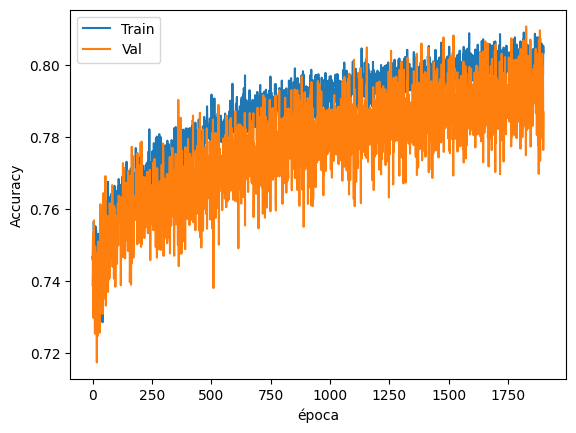

In [1180]:
plt.plot(metrics.train.accuracy[100:], label="Train")
plt.plot(metrics.val.accuracy[100:], label="Val")
plt.xlabel("época")
plt.ylabel("Accuracy")
plt.legend()

In [1604]:
class Recommender:
    def __init__(self, movienet, usernet, interactions, dataset, user_barcode_index, batch_size = 20,
                movie_embeddings = None):
        self.movienet = movienet
        self.usernet = usernet
        self.interactions = interactions
        self.dataset = dataset
        self.user_barcode_index = user_barcode_index
        self.movie_ids = dataset.movie_ids
        self.movie_embeddings = movie_embeddings
        if movie_embeddings is None:
            self.movie_embeddings = self.get_movie_embeddings(batch_size = batch_size)
    def get_movie_embeddings(self, batch_size = 20):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.movienet.to(device)
        self.movienet.eval()
        movie_ids = self.movie_ids
        embeds = []
        bar = tqdm(range(0, len(movie_ids), batch_size))
        bar.set_description_str("Calculating movie embeddings")
        for i in range(0, len(movie_ids), batch_size):
            text, features, lengths = self.dataset[i:i+batch_size]
            embed = self.movienet(text.to(device), features.to(device), lengths)
            embeds += [embed.cpu().detach().numpy()]
            bar.update()
        return np.vstack(embeds)
    
    def get_new_embedding(self, movie_ids, mean = True):
        indexs = [self.dataset.movie_id_to_idx[movie_id] for movie_id in movie_ids]
        embeddings = self.movie_embeddings[indexs]
        return embeddings.mean(axis =0) if mean else embeddings
    
    def recommend(self, user_id = None, movie_ids = None, from_embedding=None, n = "auto", 
                  sigma = 0.2, mean = False, include_input = False):
        assert not (user_id is None and movie_ids is None and from_embedding is None), "Either specify a user_id or a list of movie_ids"
        if from_embedding is None:
            if user_id is not None:
                movie_ids = self.interactions[self.interactions.userId == user_id].movieId
            user_embeddings = self.get_new_embedding(movie_ids, mean=mean)
            n = len(movie_ids) if n == "auto" else n
        else:
            user_embeddings = from_embedding

        all_movie_embeddings = np.expand_dims(self.movie_embeddings, 1)
        user_embeddings      = np.expand_dims(user_embeddings, 0)
        similarities = cosine_similarity(user_embeddings, all_movie_embeddings)
        similarities = np.exp( -(1 - similarities)**2 / (2*sigma**2))
        similarities = similarities.sum(axis =-1)

        order = np.argsort(-similarities)
        all_movie_ids = self.movie_ids.copy()[order]
        if (not include_input) and from_embedding is None:
            all_movie_ids = all_movie_ids[~np.isin(all_movie_ids, movie_ids)]
        return np.array(all_movie_ids[:n])
    
    def recommend2(self, user_id = None, movie_ids = None, from_embedding=None, n = "auto", 
                  include_input = False):
        assert not (user_id is None and movie_ids is None and from_embedding is None), "Either specify a user_id or a list of movie_ids"
        if from_embedding is None:
            if user_id is not None:
                movie_ids = self.interactions[self.interactions.userId == user_id].movieId
            input_vector = pd.Series(0, index = self.user_barcode_index)
            input_vector[movie_ids] = 1
            input_vector = torch.tensor(input_vector.to_numpy().copy(), dtype = torch.float32)
            self.usernet.eval()
            user_embedding = self.usernet.embed(input_vector.unsqueeze(0).cuda())
            
            n = len(movie_ids) if n == "auto" else n
        else:
            user_embedding = torch.tensor(from_embedding, dtype = torch.float32).cuda()
        
        movie_embeddings_tensor = torch.tensor(self.movie_embeddings, dtype = torch.float32).cuda()
        outputs = self.usernet.likeliness(user_embedding, movie_embeddings_tensor)
        outputs = outputs.detach().cpu().numpy()

        order = np.argsort(-outputs)
        all_movie_ids = self.movie_ids.copy()[order]
        if (not include_input) and from_embedding is None:
            all_movie_ids = all_movie_ids[~np.isin(all_movie_ids, movie_ids)]
        return np.array(all_movie_ids[:n])

    def accuracy(self, user_id = None, movie_ids = None, sigma = 0.2, method = 1,
                 mean = False, include_input= False, input_ratio = 0.5, n = "auto"):
        assert not (user_id is None and movie_ids is None), "Either specify a user_id or a list of movie_ids"
        if user_id is not None:
            movie_ids = self.interactions[self.interactions.userId == user_id].movieId
        movie_ids = np.array(movie_ids)
        movie_ids_in = np.random.choice(movie_ids, int(len(movie_ids)*input_ratio), replace= False)
        if include_input:
            movie_ids_target = movie_ids.copy()
        else: 
            movie_ids_target = movie_ids[~np.isin(movie_ids, movie_ids_in)]
        
        n = len(movie_ids_target) if n == "auto" else n
        
        if method == 1:
            recommendations = self.recommend(movie_ids = movie_ids_in, n=n,
                                             sigma=sigma, mean = mean, include_input = include_input)
        else:
            recommendations = self.recommend2(movie_ids = movie_ids_in, n=n,
                                             include_input = include_input)
            
        return len(set(recommendations).intersection(set(movie_ids_target))) / len(set(recommendations))
    

In [1655]:
recommender = Recommender(net2, unet, interactions, full_set, train_loader.users_barcoding.index, 
                           batch_size = 50, movie_embeddings = recommender.movie_embeddings)

In [1657]:
np.mean([recommender.accuracy(user_id, method = 1, input_ratio = 1.0, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(1,531)])

0.4518867924528302

In [1664]:
np.mean([recommender.accuracy(user_id, method = 1, input_ratio = 1, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(531,611)])

0.45999999999999996

In [1688]:
np.mean([recommender.accuracy(user_id, method = 1, input_ratio = 0.2, sigma = 0.3,
                              include_input= False, n=10) for user_id in range(1,531)])

0.06886792452830189

In [1690]:
np.mean([recommender.accuracy(user_id, method = 1, input_ratio = 0.2, sigma = 0.3,
                              include_input= False, n=10) for user_id in range(531,611)])

0.125

In [1695]:
np.mean([recommender.accuracy(user_id, method = 2, input_ratio = 1.0, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(1,531)])

0.20415094339622641

In [1697]:
np.mean([recommender.accuracy(user_id, method = 2, input_ratio = 1, sigma = 0.00001,
                              include_input= True, n = 10) for user_id in range(531,611)])

0.1825

In [1711]:
np.mean([recommender.accuracy(user_id, method = 2, input_ratio = 0.2, sigma = 0.1,
                              include_input= False, n=10) for user_id in range(1,531)])

0.1330188679245283

In [1723]:
np.mean([
np.mean([recommender.accuracy(user_id, method = 2, input_ratio = 0.2, sigma = 0.1,
                              include_input= False, n=10) for user_id in range(531,611)])
    for i in range(20)])

0.13356250000000003

In [982]:
data = next(iter(train_loader2))

In [983]:
out = unet(data[0].cuda(), data[1].cuda()).cpu().detach().numpy()

In [984]:
targ = data[2].cpu().detach().numpy()

In [985]:
targ[1, np.argsort(-out[1])[:51]].sum()/51

0.27450980392156865

In [968]:
train_loader2 = UserLoader(barcoding, barcoding_train, movie_embeddings_train, 
                          batch_size = 50, movie_batch_ratio = 1.0)

In [969]:
train_loader2

In [1065]:
embed1 = unet.embed(torch.tensor(recommender.user_loader.users_barcoding[1].to_numpy(), dtype=torch.float32).cuda().unsqueeze(0))

out1 = unet.likeliness(embed1, torch.tensor(recommender.movie_embeddings, dtype = torch.float32).cuda())

In [1066]:
torch.argmax(out1)

tensor(3057, device='cuda:0')

In [1067]:
embed2 = unet.embed(torch.tensor(recommender.user_loader.users_barcoding[1].to_numpy(), dtype=torch.float32).cuda().unsqueeze(0))

out2 = unet.likeliness(embed2, torch.tensor(movie_embeddings_train, dtype = torch.float32).cuda())

In [1068]:
barcoding_train[1].sum()

143

In [1069]:
barcoding_train[1].iloc[torch.argsort(-out2)[:143].detach().cpu()].sum()/143

0.16783216783216784

In [1062]:
torch.sort(out1, descending = True)[0][3:20]

tensor([0.9940, 0.9933, 0.9926, 0.9923, 0.9916, 0.9916, 0.9898, 0.9889, 0.9884,
        0.9884, 0.9879, 0.9871, 0.9868, 0.9865, 0.9863, 0.9857, 0.9851],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [1063]:
torch.sort(out2, descending = True)[0][:20]

tensor([0.9942, 0.9937, 0.9930, 0.9925, 0.9923, 0.9900, 0.9885, 0.9872, 0.9862,
        0.9860, 0.9852, 0.9850, 0.9839, 0.9824, 0.9819, 0.9817, 0.9815, 0.9808,
        0.9801, 0.9795], device='cuda:0', grad_fn=<SliceBackward0>)

In [1072]:
embed1 == embed2

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True]], device='cuda:0')

In [1152]:
(cosine_similarity(
    np.expand_dims(recommender.movie_embeddings, 0),
    np.expand_dims(train_loader.movie_embeddings, 1),
) >0.98).sum()

0

In [1153]:
(np.expand_dims(recommender.movie_embeddings.sum(-1), 0) == np.expand_dims(movie_embeddings_train.sum(-1), 1)).sum()

1

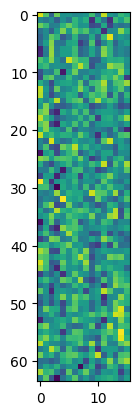

In [1254]:
embed = recommender.movie_embeddings[:64]
embed = embed/np.expand_dims(np.linalg.norm(embed, axis=1), 1)
plt.imshow(embed)

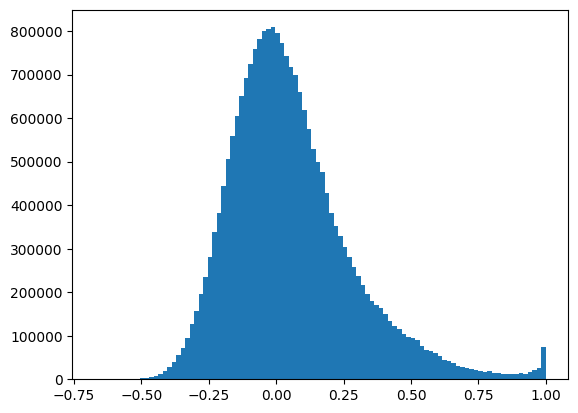

In [1364]:
embed_sim = cosine_similarity(np.expand_dims(recommender4.movie_embeddings, 0),
                 np.expand_dims(recommender4.movie_embeddings, 1)).flatten()
plt.hist(embed_sim, bins=100)
pass

In [1280]:
npbarcoding = barcoding.loc[recommender.movie_ids].to_numpy()
all_sim = np.zeros((len(npbarcoding), len(npbarcoding)))
bar = tqdm(range(len(npbarcoding)))
for i in range(len(npbarcoding)):
    all_sim[i] = cosine_similarity(npbarcoding[i], npbarcoding)
    bar.update()

  0%|          | 0/4750 [00:00<?, ?it/s]

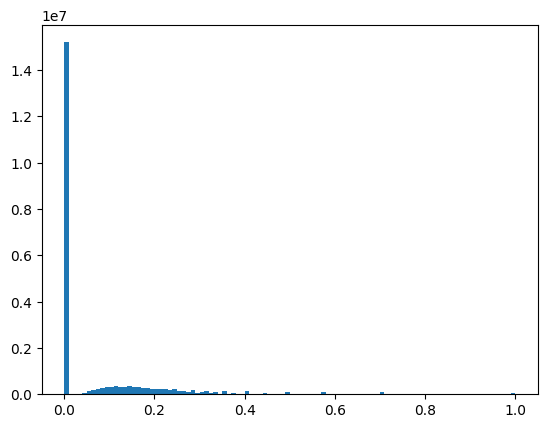

In [1290]:
plt.hist(all_sim.flatten(), bins = 100)
pass

In [1293]:
sample = np.random.choice(np.arange(embed_sim.size), replace = False, size = 10000)

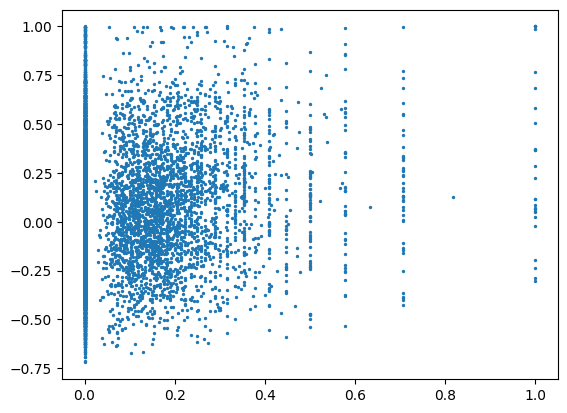

In [1296]:
plt.scatter(all_sim.flatten()[sample], embed_sim[sample], s=2)

In [1300]:
np.corrcoef(np.vstack((all_sim.flatten(), embed_sim)))

array([[1.       , 0.1146218],
       [0.1146218, 1.       ]])

In [1306]:
similarity2_weights = {i:(1-(barcoding == i).sum().sum()/barcoding.size) for i in (0,1)}

In [1308]:
def similarity2(x, y, weights):
    return np.sum([((x == v) & (y==v)).sum(-1) * weights[v] / x.shape[-1] for v in weights], axis=0)

In [1313]:
npbarcoding = barcoding.loc[recommender.movie_ids].to_numpy()
all_sim2 = np.zeros((len(npbarcoding), len(npbarcoding)))
bar = tqdm(range(len(npbarcoding)))
for i in range(len(npbarcoding)):
    all_sim2[i] = similarity2(npbarcoding[i], npbarcoding, similarity2_weights)
    bar.update()

  0%|          | 0/4750 [00:00<?, ?it/s]

In [1314]:
sim_flat = all_sim2.copy()
sim_flat[np.identity(sim_flat.shape[0]) == 1] = np.nan
sim_flat = sim_flat.flatten()
sim_flat = sim_flat[~ np.isnan(sim_flat)]
sim2_mean   = sim_flat.mean()
sim2_median = np.median(sim_flat)
sim2_max    = sim_flat.max()
sim2_min    = sim_flat.min()

In [1363]:
all_sim2_proc = all_sim2.flatten()
all_sim2_proc = np.where(all_sim2_proc < sim2_median, (all_sim2_proc - sim2_median) / (sim2_median - sim2_min), 
                            (all_sim2_proc - sim2_median) / (sim2_max - sim2_median))

In [1330]:
all_sim2.max()
sim2_max

0.37660989676041295

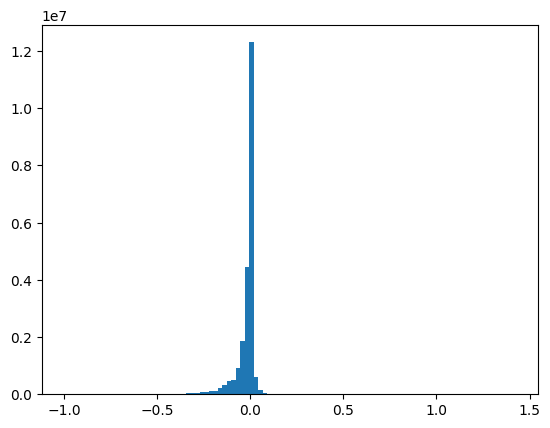

In [1365]:
plt.hist(all_sim2_proc, bins = 100)
pass

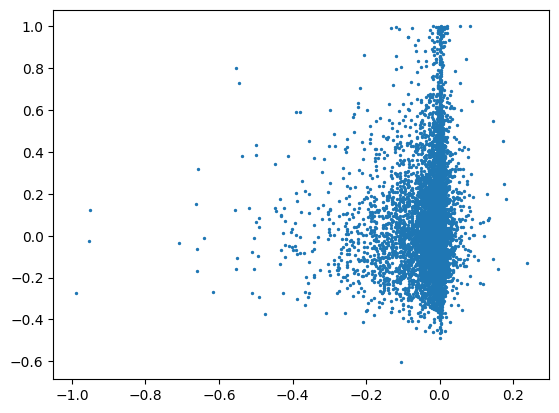

In [1366]:
plt.scatter(all_sim2_proc[sample], embed_sim[sample], s=2)

In [1367]:
np.corrcoef(np.vstack((all_sim2_proc, embed_sim)))

array([[1.       , 0.0513411],
       [0.0513411, 1.       ]])

### Modelo 4

In [1368]:
unet4 = UserNet(barcoding.shape[0], 64, 32, 256, 128, drop_prob = 0.0)

In [1369]:
from sklearn.model_selection import train_test_split

(barcoding_train, barcoding_val, movie_embeddings_train, movie_embeddings_val) = train_test_split(
    barcoding.loc[recommender4.movie_ids], recommender4.movie_embeddings, test_size = 0.1, random_state = 1991)

In [1373]:
train_loader = UserLoader(barcoding, barcoding_train, movie_embeddings_train, 
                          batch_size = 50, movie_batch_ratio = 0.26)
val_loader   = UserLoader(barcoding, barcoding_val,   movie_embeddings_val,   
                          batch_size = 50, movie_batch_ratio = 1.0)

In [1374]:
lr = 0.0005
optimizer = torch.optim.Adam(unet4.parameters(), lr=lr) #weight_decay = 0.0001
criterion = WBCELoss(50)
train_on_gpu = torch.cuda.is_available() 
train_on_gpu

True

In [1375]:
#metric15 = np.load("model_15.metrics.npy", allow_pickle = True).item()
metrics4u = Metrics([["train", "val"], ["accuracy", "loss", "k_acc"]])

In [1384]:

metrics_1, unet4 = train_model5(unet4, criterion=criterion, optimizer=optimizer, train_loader=train_loader, 
                            val_loader=val_loader, epochs=2000, save_criterium = "k_acc")

metrics4u.train.loss = metrics4u.train.loss + metrics_1.train.loss
metrics4u.val.loss   = metrics4u.val.loss   + metrics_1.val.loss
metrics4u.train.accuracy = metrics4u.train.accuracy + metrics_1.train.accuracy
metrics4u.val.accuracy   = metrics4u.val.accuracy   + metrics_1.val.accuracy
metrics4u.train.k_acc = metrics4u.train.k_acc + metrics_1.train.k_acc
metrics4u.val.k_acc   = metrics4u.val.k_acc   + metrics_1.val.k_acc

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 11m 50s


In [1404]:
torch.save(unet4.state_dict(), 'user_net4.pt')

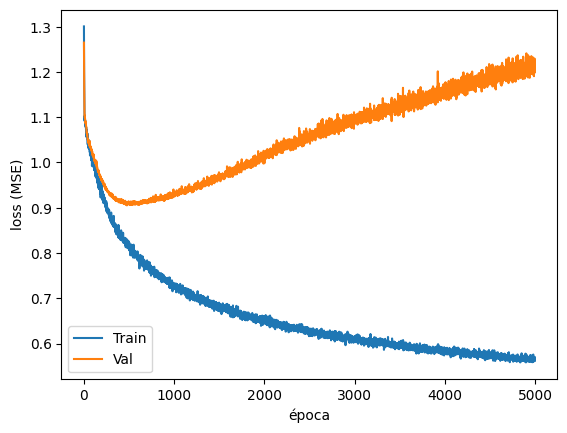

In [1385]:
plt.plot(metrics4u.train.loss, label="Train")
plt.plot(metrics4u.val.loss, label="Val")
plt.xlabel("época")
plt.ylabel("loss (MSE)")
plt.legend()

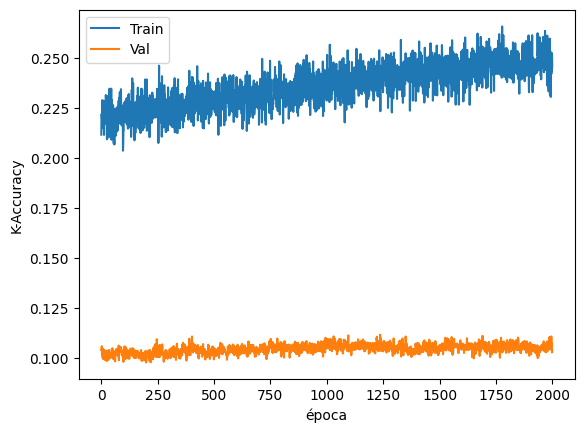

In [1386]:
plt.plot(metrics4u.train.k_acc, label="Train")
plt.plot(metrics4u.val.k_acc, label="Val")
plt.xlabel("época")
plt.ylabel("K-Accuracy")
plt.legend()

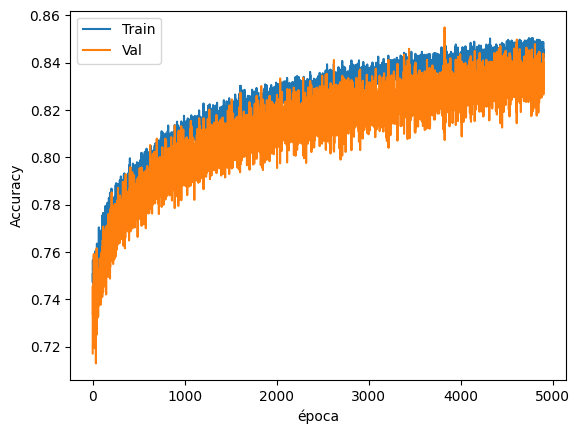

In [1387]:
plt.plot(metrics4u.train.accuracy[100:], label="Train")
plt.plot(metrics4u.val.accuracy[100:], label="Val")
plt.xlabel("época")
plt.ylabel("Accuracy")
plt.legend()

In [1487]:
train_loader.users_barcoding.index

Index([  1032.0,   6990.0,   2648.0,     48.0,   7208.0,   4010.0,   1022.0,
         1496.0,   1019.0,  73017.0,
       ...
       140627.0, 167790.0, 141131.0, 170551.0,  86892.0, 107406.0, 120919.0,
       159061.0, 158783.0, 162082.0],
      dtype='float64', name='movieId', length=4750)

In [1491]:
(barcoding.index == train_loader.users_barcoding.index).sum()

4750

In [1605]:
recommender4 = Recommender(net4, unet4, interactions, full_set, train_loader.users_barcoding.index, batch_size = 50)

  0%|          | 0/95 [00:00<?, ?it/s]

In [1724]:
np.mean([recommender4.accuracy(user_id, method = 1, input_ratio = 1.0, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(1,531)])

0.4550943396226415

In [1725]:
np.mean([recommender4.accuracy(user_id, method = 1, input_ratio = 1, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(531,611)])

0.45

In [1731]:
np.mean([recommender4.accuracy(user_id, method = 1, input_ratio = 0.2, sigma = 0.3,
                              include_input= False, n=10) for user_id in range(1,531)])

0.07716981132075472

In [1732]:
np.mean([recommender4.accuracy(user_id, method = 1, input_ratio = 0.2, sigma = 0.3,
                              include_input= False, n=10) for user_id in range(531,611)])

0.10625

In [1733]:
np.mean([recommender4.accuracy(user_id, method = 2, input_ratio = 1.0, sigma = 0.00001,
                              include_input= True, n= 10) for user_id in range(1,531)])

0.3137735849056604

In [1734]:
np.mean([recommender4.accuracy(user_id, method = 2, input_ratio = 1, sigma = 0.00001,
                              include_input= True, n=10) for user_id in range(531,611)])

0.26749999999999996

In [1738]:
np.mean([
np.mean([recommender4.accuracy(user_id, method = 2, input_ratio = 0.2, sigma = 0.1,
                              include_input= False, n=10) for user_id in range(1,531)])
    for _ in range(20)])

0.18073584905660378

In [1739]:
np.mean([
np.mean([recommender4.accuracy(user_id, method = 2, input_ratio = 0.2, sigma = 0.1,
                              include_input= False, n=10) for user_id in range(531,611)])
    for _ in range(20)])

0.191875

# Recomendación de novo

In [1564]:
def new_movie(recommender, year = 1992, origin = "American", genres = "", plot = "."):
    if type(genres) is list:
        genres = "|".join(genres)
    df = pd.DataFrame({"Release Year": [year], "Origin/Ethnicity": [origin], "genres": [genres]})
    features = ct.transform(df)
    text, length = tt(plot)
    net_in = (torch.tensor(text, dtype = torch.int32).cuda().unsqueeze(0),
              torch.tensor(features, dtype = torch.float32).cuda(),
              torch.tensor(length).unsqueeze(0))
    recommender.movienet.eval()
    embedding = recommender.movienet(*net_in).cpu().detach().numpy()
    movie_ids = recommender.recommend(from_embedding = embedding, n = 5, sigma = 0.1)
    return movies.loc[movie_ids].Title

plot = """With Spider-Man's identity now revealed, Peter asks Doctor Strange for help. When a spell goes wrong, dangerous foes from other worlds start to appear, forcing Peter to discover what it truly means to be Spider-Man."""

new_movie(recommender, year = 2021, genres = "Action|Adventure|Fantasy", plot = plot)

movieId
106491.0                     47 ronin
101112.0    oz the great and powerful
106072.0         thor: the dark world
93766.0           wrath of the titans
101025.0        jack the giant slayer
Name: Title, dtype: object

In [1417]:
movies[movies.Title.apply(lambda x:"avenger" in x.lower() or "super" in x.lower())]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,title,genres
movieId,,,,,,,,,,
2640.0,1948,superman,American,"Spencer Gordon Bennet, Thomas Carr","Kirk Alyn, Noel Neill",serial,https://en.wikipedia.org/wiki/Superman_(serial),Superman is sent to Earth by his parents just ...,superman,Action|Adventure|Sci-Fi
7060.0,1973,jesus christ superstar,American,Norman Jewison,"Ted Neeley, Carl Anderson",musical,https://en.wikipedia.org/wiki/Jesus_Christ_Sup...,The film is framed as a group of performers wh...,jesus christ superstar,Drama|Musical
2641.0,1980,superman ii,American,Richard Lester,"Gene Hackman, Christopher Reeve, Margot Kidder...","action, adventure",https://en.wikipedia.org/wiki/Superman_II,"Before the destruction of Krypton, the crimina...",superman ii,Action|Sci-Fi
2642.0,1983,superman iii,American,Richard Lester,"Christopher Reeve, Richard Pryor, Robert Vaugh...",action,https://en.wikipedia.org/wiki/Superman_III,"Gus Gorman, a chronically unemployed ne'er do ...",superman iii,Action|Adventure|Sci-Fi
3877.0,1984,supergirl,American,Jeannot Szwarc,"Helen Slater, Peter O'Toole, Faye Dunaway",superhero,https://en.wikipedia.org/wiki/Supergirl_(film),Kara Zor-El lives in an isolated Kryptonian co...,supergirl,Action|Adventure|Fantasy
2643.0,1987,superman iv: the quest for peace,American,Sidney J. Furie,"Christopher Reeve, Gene Hackman, Margot Kidder...",superhero,https://en.wikipedia.org/wiki/Superman_IV:_The...,Superman saves a spaceship of cosmonauts whose...,superman iv: the quest for peace,Action|Adventure|Sci-Fi
546.0,1993,super mario bros.,American,Rocky Morton/Annabel Jankel,"Bob Hoskins, John Leguizamo, Dennis Hopper, Sa...",science fiction,https://en.wikipedia.org/wiki/Super_Mario_Bros...,"About 65,000,000 years ago, a meteorite crashe...",super mario bros.,Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
2907.0,1999,superstar,American,Bruce McCulloch,"Molly Shannon, Will Ferrell, Harland Williams",comedy,https://en.wikipedia.org/wiki/Superstar_(1999_...,Mary Katherine Gallagher (Shannon) is an Irish...,superstar,Comedy
3190.0,2000,supernova,American,Walter Hill,"James Spader, Angela Bassett",science fiction,https://en.wikipedia.org/wiki/Supernova_(2000_...,Supernova chronicles the search-and-rescue pat...,supernova,Adventure|Sci-Fi|Thriller


In [1422]:
movies[movies.Genre == "superhero"].index[:15]

Index([ 3877.0,  2643.0,  1377.0,   153.0,  5349.0,  6157.0,  8666.0,  7373.0,
        8636.0, 33794.0, 34150.0, 45732.0, 46530.0, 51077.0, 52722.0],
      dtype='float64', name='movieId')

In [1426]:
?recommender4.recommend2

In [1443]:
superhero_ids = movies[movies.Genre == "superhero"].index
animation_ids = movies[movies.genres.apply(lambda x: "Animation" in x)].index
recommender4.accuracy(movie_ids = animation_ids, method = 2, input_ratio = 0.5, include_input = False)

0.28703703703703703

In [1442]:
recs = recommender4.recommend2(movie_ids = animation_ids, n = 50, include_input=True)
movies.loc[recs].Title

movieId
56152.0                                       enchanted
81847.0                                         tangled
8360.0                                          shrek 2
84944.0                                           rango
32031.0                                          robots
63859.0                                            bolt
4306.0                                            shrek
43869.0                                  curious george
45431.0                                  over the hedge
1064.0                  aladdin and the king of thieves
58299.0                             horton hears a who!
33615.0                                      madagascar
93272.0                            dr. seuss' the lorax
52287.0                              meet the robinsons
53121.0                                 shrek the third
40339.0                                  chicken little
78499.0                                     toy story 3
49274.0                                 

In [1583]:
peliculas_de_monitos =[
    90647, 1, 2294, 1907, 3114, 3745, 
    4366, 4886, 4306, 5218, 5444, 6377,
    8360, 45431, 71264, 76093, 78499, 
    95167, 112175, 152081, 177765
]

In [ ]:
90647,1,2294,1907,3114,3745,4366,4886,4306,5218,5444,6377,8360,45431,71264,76093,78499,95167,112175,152081,177765

In [1587]:
movies.loc[peliculas_de_monitos].Title

movieId
90647.0                         puss in boots
1.0                                 toy story
2294.0                                   antz
1907.0                                  mulan
3114.0                            toy story 2
3745.0                             titan a.e.
4366.0              atlantis: the lost empire
4886.0                         monsters, inc.
4306.0                                  shrek
5218.0                                ice age
5444.0                          lilo & stitch
6377.0                           finding nemo
8360.0                                shrek 2
45431.0                        over the hedge
71264.0     cloudy with a chance of meatballs
76093.0              how to train your dragon
78499.0                           toy story 3
95167.0                                 brave
112175.0           how to train your dragon 2
152081.0                             zootopia
177765.0                                 coco
Name: Title, dtype: object

In [1586]:
movies.loc[recommender4.recommend2(movie_ids = peliculas_de_monitos)].Title

movieId
30793.0                charlie and the chocolate factory
81847.0                                          tangled
71745.0                        where the wild things are
8368.0          harry potter and the prisoner of azkaban
81834.0     harry potter and the deathly hallows: part 1
106002.0                                    ender's game
56152.0                                        enchanted
53121.0                                  shrek the third
32031.0                                           robots
3751.0                                       chicken run
88125.0     harry potter and the deathly hallows: part 2
60074.0                                          hancock
33615.0                                       madagascar
78105.0              prince of persia: the sands of time
43869.0                                   curious george
51662.0                                              300
54001.0        harry potter and the order of the phoenix
4990.0                 

In [1601]:
movies.Plot[movies.Title.apply(lambda x: "potter" in x)].iloc[0]

'Harry Potter spends the summer with The Dursleys without receiving letters from his Hogwarts friends. In his room, Harry meets Dobby, a house-elf, who warns him of a peril that will take shape if he returns to Hogwarts, and reveals he intercepted his friends\' letters, and destroys a cake. The Dursleys lock Harry up, but Ron, Fred and George Weasley rescue him in their father\'s flying car.\r\nWhile purchasing school supplies, Harry and the Weasley family encounter Rubeus Hagrid and Hermione Granger, and they attend a book-signing by celebrity wizard Gilderoy Lockhart, who announces that he will be the new Defence Against the Dark Arts teacher. During a small confrontation with Draco Malfoy, Harry meets Malfoy\'s father, Lucius, who slips a book in Ginny Weasley\'s belongings. When Harry and Ron are blocked from entering Platform Nine and Three-Quarters, they fly to Hogwarts in the flying car, crashing into the Whomping Willow upon arrival. Ron\'s wand is damaged, and the car ejects t

In [1595]:
"""Late one night, Albus Dumbledore and Minerva McGonagall, professors at Hogwarts School of Witchcraft and Wizardry, along with groundskeeper Rubeus Hagrid, deliver an orphaned infant wizard named Harry Potter to his Muggle aunt and uncle, Petunia and Vernon Dursley, his only living relatives. Ten years later, just before Harry's eleventh birthday, owls begin delivering letters addressed to him. When the abusive Dursleys adamantly refuse to allow Harry to open any and flee to an island hut, Hagrid arrives to personally deliver Harry's letter of acceptance to Hogwarts. Hagrid also reveals that Harry's parents, James and Lily, were killed by a dark wizard named Lord Voldemort. The killing curse that Voldemort had cast towards Harry rebounded, destroying Voldemort's body and giving Harry his lightning-bolt scar. Hagrid then takes Harry to Diagon Alley for school supplies and gives him a pet snowy owl whom he names Hedwig. Harry buys a wand that is connected to Voldemort's own wand. At King's Cross station, Harry boards the Hogwarts Express train, and meets fellow students Ron Weasley and Hermione Granger during the journey. Arriving at Hogwarts, Harry also meets Draco Malfoy, who is from a wealthy wizard family; the two immediately form a rivalry. The students assemble in the Great Hall where the Sorting Hat sorts the first-years into four respective houses: Gryffindor, Hufflepuff, Ravenclaw, and Slytherin. Harry is placed into Gryffindor alongside Ron and Hermione, while Draco is placed into Slytherin, a house noted for dark wizards. As he studies magic, Harry learns more about his parents and Voldemort, and his natural talent for broomstick flying gets him recruited for Gryffindor's Quidditch team as the youngest Seeker in a century. While returning to the Gryffindor common room, the staircases change paths, leading Harry, Ron and Hermione to the third floor, which is forbidden to students. There they discover a giant three-headed dog named Fluffy. On Halloween, Ron insults Hermione after she shows off in Charms class; upset, she spends the entire afternoon crying in the girls' bathroom. That evening, a giant marauding troll enters it, but Harry and Ron save Hermione, and the three make up and become close friends after Hermione takes the blame for the incident by claiming she went looking for the troll. The trio discover that Fluffy is guarding the philosopher's stone, a magical object that can turn metal into gold and produce an immortality elixir. Harry suspects that Potions teacher and head of Slytherin House, Severus Snape, wants the stone to return Voldemort to physical form. When Hagrid accidentally reveals that music puts Fluffy asleep, Harry, Ron and Hermione decide to find the stone before Snape. Fluffy is already asleep, but the trio face other barriers, including a deadly plant called Devil's Snare, a room filled with aggressive flying keys, and a giant chess game that knocks out Ron. After overcoming the barriers, Harry encounters Defence Against the Dark Arts teacher Quirinus Quirrell who wants the stone; Snape had figured it out and had been protecting Harry. Quirrell removes his turban to reveal a weakened Voldemort living on the back of his head. Dumbledore's protective enchantment places the stone in Harry's possession. Voldemort attempts to bargain the stone from Harry in exchange for resurrecting his parents, but Harry sees through his trick and refuses. Quirrell attempts to kill Harry. When Harry touches Quirrell's skin, it burns Quirrell, reducing him to ashes. Voldemort's soul rises from the pile and escapes, knocking out Harry as it passes through him. Harry recovers in the school infirmary. Dumbledore tells him the stone has been destroyed to prevent misuse, and that Ron and Hermione are safe. He also reveals how Harry defeated Quirrell: when Lily died to save Harry, a love-based protection against Voldemort was placed on him. At the end-of-school-year feast, Harry, Ron, and Hermione are rewarded extra house points for their heroism, tying Gryffindor for first place with Slytherin; Dumbledore then awards ten points to their housemate Neville Longbottom for having had the courage to stand up to the trio, granting Gryffindor the House Cup. Harry returns to the Dursleys for the summer, happy to finally have a real home at Hogwarts."""

"Late one night, Albus Dumbledore and Minerva McGonagall, professors at Hogwarts School of Witchcraft and Wizardry, along with groundskeeper Rubeus Hagrid, deliver an orphaned infant wizard named Harry Potter to his Muggle aunt and uncle, Petunia and Vernon Dursley, his only living relatives. Ten years later, just before Harry's eleventh birthday, owls begin delivering letters addressed to him. When the abusive Dursleys adamantly refuse to allow Harry to open any and flee to an island hut, Hagrid arrives to personally deliver Harry's letter of acceptance to Hogwarts. Hagrid also reveals that Harry's parents, James and Lily, were killed by a dark wizard named Lord Voldemort. The killing curse that Voldemort had cast towards Harry rebounded, destroying Voldemort's body and giving Harry his lightning-bolt scar. Hagrid then takes Harry to Diagon Alley for school supplies and gives him a pet snowy owl whom he names Hedwig. Harry buys a wand that is connected to Voldemort's own wand. At King